In [1]:
!pip install -r requirement.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 66.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 109.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 91.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 130.1 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 163.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.6/362.6 kB 55.5 MB/s eta 0:00:00
   ━━

In [2]:
pip install gdown 

Note: you may need to restart the kernel to use updated packages.


In [4]:
!gdown 1kQWXnghhRhZ1U06x_l3UXOUiCYy1doTX

97.17s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Downloading...
From (original): https://drive.google.com/uc?id=1kQWXnghhRhZ1U06x_l3UXOUiCYy1doTX
From (redirected): https://drive.google.com/uc?id=1kQWXnghhRhZ1U06x_l3UXOUiCYy1doTX&confirm=t&uuid=51e6c1d1-1ff4-4065-b01e-255325eff2ef
To: /root/AIUET/DakLak_Full_Merged.tif
100%|██████████████████████████████████████| 14.1G/14.1G [05:16<00:00, 44.4MB/s]


In [12]:
import rasterio
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import torchvision.transforms.functional as TF
import random
import os
import math # Thêm math cho một số tính toán nếu cần

# ================================================================================
# CANOPY HEIGHT MAPPING - UNET++ TRAINING (FINAL OPTIMIZED)
# ================================================================================

# ================= 1. CONFIGURATION =================
class Config:
    # --- File Paths ---
    TIFF_PATH = "../DakLak_Full_Merged.tif"
    MODEL_SAVE_PATH = "best_unetpp_canopy_height.pth"
    
    # --- Training Hyperparameters ---
    PATCH_SIZE = 256
    BATCH_SIZE = 8
    LR = 1e-4  # LR ban đầu cho AdamW/Plateau
    EPOCHS = 200
    EARLY_STOP_PATIENCE = 15
    
    # --- Data Params ---
    MAX_CANOPY_HEIGHT = 100.0  
    
    # --- Band Configuration ---
    # Band 1: GEDI Label (RH98) - Target
    # Band 2-15: Sentinel-1 & Sentinel-2 Inputs (14 kênh)
    LABEL_BAND_IDX = 1
    INPUT_BAND_INDICES = list(range(2, 14))
    INPUT_CHANNELS = 12 
    
    # --- System ---
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    NUM_WORKERS = 4 
    PIN_MEMORY = True
    
    # --- Split Ratio & Seed ---
    TRAIN_RATIO = 0.8
    VAL_RATIO = 0.2
    SEED = 42

# ================= 2. DATASET =================
class CanopyHeightDataset(Dataset):
    def __init__(self, tif_path, config, augment=True):
        self.tif_path = tif_path
        self.cfg = config
        self.augment = augment
        self.windows = []
        
        print(f"\n{'='*60}")
        print(f"DATASET INITIALIZATION")
        print(f"{'='*60}")
        
        if not os.path.exists(tif_path):
            raise FileNotFoundError(f"❌ Không tìm thấy file: {tif_path}")

        with rasterio.open(tif_path) as src:
            self.H, self.W = src.height, src.width
            print(f"Image Size: {self.H} x {self.W}")
            print("Loading label band to generate patches...")
            
            try:
                label_data = src.read(config.LABEL_BAND_IDX)
            except Exception as e:
                print(f"❌ Error reading label: {e}")
                return
        
        patch_size = config.PATCH_SIZE
        stride = patch_size
        
        n_rows = (self.H - patch_size) // stride + 1
        n_cols = (self.W - patch_size) // stride + 1
        
        gedi_pixels_total = 0
        
        for i in range(n_rows):
            for j in range(n_cols):
                row_off = i * stride
                col_off = j * stride
                
                window = rasterio.windows.Window(col_off, row_off, patch_size, patch_size)
                patch_label = label_data[row_off:row_off+patch_size, col_off:col_off+patch_size]
                
                # LỌC: Chỉ lấy patch có ít nhất 1 điểm GEDI hợp lệ (>0.5m)
                valid_gedi = ((patch_label > 0.5) & (patch_label < 100)).sum()
                
                if valid_gedi > 0:
                    self.windows.append(window)
                    gedi_pixels_total += valid_gedi
                    
        print(f"✅ Valid Patches found: {len(self.windows)}")
        print(f"✅ Total GEDI Pixels: {gedi_pixels_total}")
        print(f"{'='*60}\n")

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        window = self.windows[idx]
        
        with rasterio.open(self.tif_path) as src:
            img = src.read(self.cfg.INPUT_BAND_INDICES, window=window).astype('float32')
            label = src.read(self.cfg.LABEL_BAND_IDX, window=window).astype('float32')
        
        img = np.nan_to_num(img, nan=0.0)
        img = np.clip(img, 0, 1.0)
        
        label = np.nan_to_num(label, nan=0.0)
        mask = ((label > 0.5) & (label < 100.0)).astype('float32')
        
        label = np.clip(label, 0, self.cfg.MAX_CANOPY_HEIGHT) / self.cfg.MAX_CANOPY_HEIGHT
        label = label * mask 
        
        img_t = torch.from_numpy(img)
        label_t = torch.from_numpy(label).unsqueeze(0)
        mask_t = torch.from_numpy(mask).unsqueeze(0)
        
        # Augmentation
        if self.augment:
            if random.random() > 0.5:
                img_t = TF.hflip(img_t)
                label_t = TF.hflip(label_t)
                mask_t = TF.hflip(mask_t)
            if random.random() > 0.5:
                img_t = TF.vflip(img_t)
                label_t = TF.vflip(label_t)
                mask_t = TF.vflip(mask_t)
            if random.random() > 0.5:
                angle = random.choice([90, 180, 270])
                img_t = TF.rotate(img_t, angle)
                label_t = TF.rotate(label_t, angle)
                mask_t = TF.rotate(mask_t, angle)
                
        return img_t, label_t, mask_t

# ================= 3. MODEL (UNet++) =================
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.conv(x)

class UNetPlusPlus(nn.Module):
    def __init__(self, in_channels=12, out_channels=1):
        super(UNetPlusPlus, self).__init__()
        nb_filter = [32, 64, 128, 256, 512]
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv0_0 = ConvBlock(in_channels, nb_filter[0])
        self.conv1_0 = ConvBlock(nb_filter[0], nb_filter[1])
        self.conv2_0 = ConvBlock(nb_filter[1], nb_filter[2])
        self.conv3_0 = ConvBlock(nb_filter[2], nb_filter[3])
        self.conv4_0 = ConvBlock(nb_filter[3], nb_filter[4])
        
        self.conv0_1 = ConvBlock(nb_filter[0]+nb_filter[1], nb_filter[0])
        self.conv1_1 = ConvBlock(nb_filter[1]+nb_filter[2], nb_filter[1])
        self.conv2_1 = ConvBlock(nb_filter[2]+nb_filter[3], nb_filter[2])
        self.conv3_1 = ConvBlock(nb_filter[3]+nb_filter[4], nb_filter[3])
        
        self.conv0_2 = ConvBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0])
        self.conv1_2 = ConvBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1])
        self.conv2_2 = ConvBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2])
        
        self.conv0_3 = ConvBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0])
        self.conv1_3 = ConvBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1])
        
        self.conv0_4 = ConvBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0])
        
        self.final = nn.Sequential(
            nn.Conv2d(nb_filter[0], out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))
        
        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))
        
        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))
        
        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))
        
        output = self.final(x0_4)
        return output

# ================= 4. LOSS & METRICS =================
def masked_mae_loss(preds, targets, mask):
    """Tính Loss trên thang đo [0, 1] cho Regression (MAE)."""
    diff = torch.abs(preds - targets) * mask
    loss = diff.sum() / (mask.sum() + 1e-6)
    return loss

def calculate_metrics(preds, targets, mask, max_height=100.0):
    """Tính Metrics báo cáo (R2, RMSE, MAE) trên thang đo THỰC TẾ (mét)."""
    preds_m = preds * max_height
    targets_m = targets * max_height
    
    p = preds_m.detach().cpu().numpy().flatten()
    t = targets_m.detach().cpu().numpy().flatten()
    m = mask.detach().cpu().numpy().flatten()
    
    valid_indices = m > 0
    if valid_indices.sum() < 2:
        return {'r2': 0.0, 'rmse': 0.0, 'mae': 0.0}
        
    p_valid = p[valid_indices]
    t_valid = t[valid_indices]
    
    valid_mask = np.isfinite(p_valid) & np.isfinite(t_valid)
    p_valid = p_valid[valid_mask]
    t_valid = t_valid[valid_mask]
    
    if len(p_valid) < 2:
        return {'r2': 0.0, 'rmse': 0.0, 'mae': 0.0}
        
    r2 = r2_score(t_valid, p_valid)
    rmse = np.sqrt(mean_squared_error(t_valid, p_valid))
    mae = mean_absolute_error(t_valid, p_valid)
    
    return {'r2': r2, 'rmse': rmse, 'mae': mae}

# ================= 5. TRAINING ROUTINE =================
def train_one_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    epoch_loss = 0
    metrics_accum = {'r2': 0, 'rmse': 0, 'mae': 0}
    
    pbar = tqdm(dataloader, desc="Train")
    for img, label, mask in pbar:
        img, label, mask = img.to(device), label.to(device), mask.to(device)
        
        optimizer.zero_grad()
        preds = model(img)
        
        loss = masked_mae_loss(preds, label, mask)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # NOTE: Scheduler.step() được gọi trong main() nếu dùng Plateau
        if scheduler: # Chỉ chạy nếu là OneCycleLR
             scheduler.step()
            
        epoch_loss += loss.item()
        
        with torch.no_grad():
            batch_metrics = calculate_metrics(preds, label, mask, Config.MAX_CANOPY_HEIGHT)
            for k in metrics_accum:
                metrics_accum[k] += batch_metrics[k]
                
        pbar.set_postfix({'Loss': f"{loss.item():.4f}", 'MAE': f"{batch_metrics['mae']:.2f}m"})
        
    avg_loss = epoch_loss / len(dataloader)
    avg_metrics = {k: v / len(dataloader) for k, v in metrics_accum.items()}
    return avg_loss, avg_metrics

def validate(model, dataloader, device):
    model.eval()
    val_loss = 0
    metrics_accum = {'r2': 0, 'rmse': 0, 'mae': 0}
    
    with torch.no_grad():
        for img, label, mask in tqdm(dataloader, desc="Val"):
            img, label, mask = img.to(device), label.to(device), mask.to(device)
            
            preds = model(img)
            loss = masked_mae_loss(preds, label, mask)
            
            val_loss += loss.item()
            
            batch_metrics = calculate_metrics(preds, label, mask, Config.MAX_CANOPY_HEIGHT)
            for k in metrics_accum:
                metrics_accum[k] += batch_metrics[k]
                
    avg_loss = val_loss / len(dataloader)
    avg_metrics = {k: v / len(dataloader) for k, v in metrics_accum.items()}
    return avg_loss, avg_metrics


# ================= 6. MAIN (SỬ DỤNG REDUCELRONPLATEAU) =================
def main():
    cfg = Config()
    
    # 1. Reproducibility
    random.seed(cfg.SEED)
    np.random.seed(cfg.SEED)
    torch.manual_seed(cfg.SEED)
    
    # 2. Dataset Setup
    if not os.path.exists(cfg.TIFF_PATH):
        print(f"❌ Error: Not found {cfg.TIFF_PATH}")
        return

    full_dataset = CanopyHeightDataset(cfg.TIFF_PATH, cfg, augment=False) # Tắt Augmentation khi debug/mắc kẹt
    
    train_size = int(cfg.TRAIN_RATIO * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_ds, val_ds = torch.utils.data.random_split(
        full_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(cfg.SEED)
    )
    
    train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=cfg.NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=cfg.NUM_WORKERS, pin_memory=True)
    
    print(f"Train size: {len(train_ds)} patches")
    print(f"Val size:   {len(val_ds)} patches")
    
    # 3. Model & Optimizer Setup
    
    # Khởi tạo model và optimizer CHÍNH THỨC
    model = UNetPlusPlus(in_channels=cfg.INPUT_CHANNELS, out_channels=1).to(cfg.DEVICE)
    
    # SỬ DỤNG WEIGHT_DECAY TĂNG LÊN 5E-4 VÀ LR BAN ĐẦU
    optimizer = optim.AdamW(model.parameters(), lr=cfg.LR, weight_decay=5e-4) 
    
    # KHỞI TẠO SCHEDULER THEO HIỆU SUẤT (ReduceLROnPlateau)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',         # Theo dõi Loss Validation (Loss giảm)
        factor=0.5,         # Giảm LR đi 50%
        patience=5,         # Chờ 5 Epoch không cải thiện mới giảm
        min_lr=1e-7,        # LR tối thiểu
     
    )
    
    # 4. Loop
    # NOTE: Nếu bạn muốn Fine-tune từ Epoch 11, hãy uncomment dòng sau:
    # model.load_state_dict(torch.load(cfg.MODEL_SAVE_PATH))
    best_mae = float('inf')
    patience = 0
    
    print("\n🚀 START TRAINING with ReduceLROnPlateau...")
    for epoch in range(1, cfg.EPOCHS+1):
        # Truyền None cho train_one_epoch để không gọi scheduler.step() sau mỗi batch
        train_loss, train_m = train_one_epoch(model, train_loader, optimizer, None, cfg.DEVICE) 
        val_loss, val_m = validate(model, val_loader, cfg.DEVICE)
        
        # GỌI SCHEDULER.STEP() VỚI VALIDATION LOSS
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch}/{cfg.EPOCHS}")
        print(f"  Train Loss: {train_loss:.4f} | MAE: {train_m['mae']:.2f}m | RMSE: {train_m['rmse']:.2f}m | R2: {train_m['r2']:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | MAE: {val_m['mae']:.2f}m | RMSE: {val_m['rmse']:.2f}m | R2: {val_m['r2']:.4f}")
        
        # Save Best Model theo MAE
        if val_m['mae'] < best_mae:
            best_mae = val_m['mae']
            patience = 0
            torch.save(model.state_dict(), cfg.MODEL_SAVE_PATH)
            print(f"  ✅ Model Saved (New Best MAE: {best_mae:.4f}m)")
        else:
            patience += 1
            print(f"  ⚠️ No improve ({patience}/{cfg.EARLY_STOP_PATIENCE})")
            
        if patience >= cfg.EARLY_STOP_PATIENCE:
            print("🛑 Early Stopping!")
            break

if __name__ == "__main__":
    main()


DATASET INITIALIZATION
Image Size: 13879 x 16445
Loading label band to generate patches...


✅ Valid Patches found: 2120
✅ Total GEDI Pixels: 481299

Train size: 1696 patches
Val size:   424 patches

🚀 START TRAINING with ReduceLROnPlateau...


Val: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


Epoch 1/200
  Train Loss: 0.2319 | MAE: 23.19m | RMSE: 26.71m | R2: -6.5477
  Val   Loss: 0.1661 | MAE: 16.61m | RMSE: 19.62m | R2: -2.8355
  ✅ Model Saved (New Best MAE: 16.6101m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 2/200
  Train Loss: 0.1828 | MAE: 18.28m | RMSE: 21.54m | R2: -3.8292
  Val   Loss: 0.1670 | MAE: 16.70m | RMSE: 20.62m | R2: -3.2726
  ⚠️ No improve (1/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 3/200
  Train Loss: 0.1624 | MAE: 16.24m | RMSE: 19.33m | R2: -2.9499
  Val   Loss: 0.1394 | MAE: 13.94m | RMSE: 16.91m | R2: -1.8424
  ✅ Model Saved (New Best MAE: 13.9382m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 4/200
  Train Loss: 0.1470 | MAE: 14.70m | RMSE: 17.65m | R2: -2.1189
  Val   Loss: 0.1348 | MAE: 13.48m | RMSE: 16.05m | R2: -1.5656
  ✅ Model Saved (New Best MAE: 13.4819m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 5/200
  Train Loss: 0.1356 | MAE: 13.56m | RMSE: 16.38m | R2: -1.7337
  Val   Loss: 0.1251 | MAE: 12.51m | RMSE: 15.16m | R2: -1.3039
  ✅ Model Saved (New Best MAE: 12.5056m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


Epoch 6/200
  Train Loss: 0.1244 | MAE: 12.44m | RMSE: 15.05m | R2: -1.2650
  Val   Loss: 0.1156 | MAE: 11.56m | RMSE: 14.07m | R2: -0.9983
  ✅ Model Saved (New Best MAE: 11.5644m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


Epoch 7/200
  Train Loss: 0.1144 | MAE: 11.44m | RMSE: 13.79m | R2: -0.9749
  Val   Loss: 0.1054 | MAE: 10.54m | RMSE: 12.90m | R2: -0.6646
  ✅ Model Saved (New Best MAE: 10.5373m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 8/200
  Train Loss: 0.1054 | MAE: 10.54m | RMSE: 12.79m | R2: -0.7174
  Val   Loss: 0.1037 | MAE: 10.37m | RMSE: 12.57m | R2: -0.5758
  ✅ Model Saved (New Best MAE: 10.3656m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.23it/s]


Epoch 9/200
  Train Loss: 0.0965 | MAE: 9.65m | RMSE: 11.80m | R2: -0.4340
  Val   Loss: 0.0814 | MAE: 8.14m | RMSE: 10.04m | R2: 0.0010
  ✅ Model Saved (New Best MAE: 8.1399m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


Epoch 10/200
  Train Loss: 0.0899 | MAE: 8.99m | RMSE: 11.20m | R2: -0.2607
  Val   Loss: 0.0805 | MAE: 8.05m | RMSE: 10.04m | R2: -0.0008
  ✅ Model Saved (New Best MAE: 8.0452m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 11/200
  Train Loss: 0.0842 | MAE: 8.42m | RMSE: 10.51m | R2: -0.1643
  Val   Loss: 0.0792 | MAE: 7.92m | RMSE: 9.91m | R2: 0.0246
  ✅ Model Saved (New Best MAE: 7.9239m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 12/200
  Train Loss: 0.0782 | MAE: 7.82m | RMSE: 9.86m | R2: 0.0204
  Val   Loss: 0.0709 | MAE: 7.09m | RMSE: 9.18m | R2: 0.1653
  ✅ Model Saved (New Best MAE: 7.0906m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


Epoch 13/200
  Train Loss: 0.0730 | MAE: 7.30m | RMSE: 9.26m | R2: 0.1392
  Val   Loss: 0.0750 | MAE: 7.50m | RMSE: 9.23m | R2: 0.1592
  ⚠️ No improve (1/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 14/200
  Train Loss: 0.0684 | MAE: 6.84m | RMSE: 8.80m | R2: 0.1808
  Val   Loss: 0.0581 | MAE: 5.81m | RMSE: 7.71m | R2: 0.4152
  ✅ Model Saved (New Best MAE: 5.8106m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 15/200
  Train Loss: 0.0646 | MAE: 6.46m | RMSE: 8.40m | R2: 0.2733
  Val   Loss: 0.0606 | MAE: 6.06m | RMSE: 7.86m | R2: 0.3927
  ⚠️ No improve (1/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 16/200
  Train Loss: 0.0622 | MAE: 6.22m | RMSE: 8.22m | R2: 0.2944
  Val   Loss: 0.0612 | MAE: 6.12m | RMSE: 8.10m | R2: 0.3555
  ⚠️ No improve (2/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


Epoch 17/200
  Train Loss: 0.0591 | MAE: 5.91m | RMSE: 7.83m | R2: 0.3929
  Val   Loss: 0.0550 | MAE: 5.50m | RMSE: 7.30m | R2: 0.4769
  ✅ Model Saved (New Best MAE: 5.4970m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 18/200
  Train Loss: 0.0577 | MAE: 5.77m | RMSE: 7.72m | R2: 0.3965
  Val   Loss: 0.0512 | MAE: 5.12m | RMSE: 7.12m | R2: 0.5038
  ✅ Model Saved (New Best MAE: 5.1239m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


Epoch 19/200
  Train Loss: 0.0546 | MAE: 5.46m | RMSE: 7.45m | R2: 0.4413
  Val   Loss: 0.0511 | MAE: 5.11m | RMSE: 7.12m | R2: 0.5025
  ✅ Model Saved (New Best MAE: 5.1083m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 20/200
  Train Loss: 0.0524 | MAE: 5.24m | RMSE: 7.20m | R2: 0.4736
  Val   Loss: 0.0520 | MAE: 5.20m | RMSE: 7.17m | R2: 0.4951
  ⚠️ No improve (1/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.20it/s]


Epoch 21/200
  Train Loss: 0.0513 | MAE: 5.13m | RMSE: 7.08m | R2: 0.5034
  Val   Loss: 0.0453 | MAE: 4.53m | RMSE: 6.72m | R2: 0.5571
  ✅ Model Saved (New Best MAE: 4.5339m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 22/200
  Train Loss: 0.0495 | MAE: 4.95m | RMSE: 6.91m | R2: 0.5121
  Val   Loss: 0.0472 | MAE: 4.72m | RMSE: 6.70m | R2: 0.5595
  ⚠️ No improve (1/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


Epoch 23/200
  Train Loss: 0.0483 | MAE: 4.83m | RMSE: 6.83m | R2: 0.5401
  Val   Loss: 0.0473 | MAE: 4.73m | RMSE: 6.75m | R2: 0.5515
  ⚠️ No improve (2/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


Epoch 24/200
  Train Loss: 0.0482 | MAE: 4.82m | RMSE: 6.96m | R2: 0.5107
  Val   Loss: 0.0446 | MAE: 4.46m | RMSE: 6.55m | R2: 0.5797
  ✅ Model Saved (New Best MAE: 4.4625m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


Epoch 25/200
  Train Loss: 0.0472 | MAE: 4.72m | RMSE: 6.86m | R2: 0.5289
  Val   Loss: 0.0438 | MAE: 4.38m | RMSE: 6.47m | R2: 0.5893
  ✅ Model Saved (New Best MAE: 4.3775m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 26/200
  Train Loss: 0.0464 | MAE: 4.64m | RMSE: 6.77m | R2: 0.5392
  Val   Loss: 0.0433 | MAE: 4.33m | RMSE: 6.47m | R2: 0.5901
  ✅ Model Saved (New Best MAE: 4.3282m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 27/200
  Train Loss: 0.0454 | MAE: 4.54m | RMSE: 6.56m | R2: 0.5743
  Val   Loss: 0.0433 | MAE: 4.33m | RMSE: 6.60m | R2: 0.5725
  ✅ Model Saved (New Best MAE: 4.3278m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.19it/s]


Epoch 28/200
  Train Loss: 0.0450 | MAE: 4.50m | RMSE: 6.65m | R2: 0.5610
  Val   Loss: 0.0463 | MAE: 4.63m | RMSE: 6.62m | R2: 0.5699
  ⚠️ No improve (1/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.24it/s]


Epoch 29/200
  Train Loss: 0.0444 | MAE: 4.44m | RMSE: 6.56m | R2: 0.5787
  Val   Loss: 0.0440 | MAE: 4.40m | RMSE: 6.57m | R2: 0.5747
  ⚠️ No improve (2/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 30/200
  Train Loss: 0.0439 | MAE: 4.39m | RMSE: 6.52m | R2: 0.5763
  Val   Loss: 0.0410 | MAE: 4.10m | RMSE: 6.35m | R2: 0.6052
  ✅ Model Saved (New Best MAE: 4.1046m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


Epoch 31/200
  Train Loss: 0.0438 | MAE: 4.38m | RMSE: 6.55m | R2: 0.5756
  Val   Loss: 0.0493 | MAE: 4.93m | RMSE: 6.82m | R2: 0.5445
  ⚠️ No improve (1/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.24it/s]


Epoch 32/200
  Train Loss: 0.0437 | MAE: 4.37m | RMSE: 6.57m | R2: 0.5666
  Val   Loss: 0.0407 | MAE: 4.07m | RMSE: 6.31m | R2: 0.6097
  ✅ Model Saved (New Best MAE: 4.0742m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.23it/s]


Epoch 33/200
  Train Loss: 0.0429 | MAE: 4.29m | RMSE: 6.45m | R2: 0.5933
  Val   Loss: 0.0416 | MAE: 4.16m | RMSE: 6.41m | R2: 0.5977
  ⚠️ No improve (1/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


Epoch 34/200
  Train Loss: 0.0428 | MAE: 4.28m | RMSE: 6.46m | R2: 0.5933
  Val   Loss: 0.0433 | MAE: 4.33m | RMSE: 6.45m | R2: 0.5922
  ⚠️ No improve (2/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


Epoch 35/200
  Train Loss: 0.0424 | MAE: 4.24m | RMSE: 6.41m | R2: 0.5985
  Val   Loss: 0.0418 | MAE: 4.18m | RMSE: 6.32m | R2: 0.6087
  ⚠️ No improve (3/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 36/200
  Train Loss: 0.0424 | MAE: 4.24m | RMSE: 6.43m | R2: 0.5982
  Val   Loss: 0.0439 | MAE: 4.39m | RMSE: 6.50m | R2: 0.5840
  ⚠️ No improve (4/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.14it/s]


Epoch 37/200
  Train Loss: 0.0426 | MAE: 4.26m | RMSE: 6.53m | R2: 0.5757
  Val   Loss: 0.0427 | MAE: 4.27m | RMSE: 6.61m | R2: 0.5689
  ⚠️ No improve (5/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 38/200
  Train Loss: 0.0427 | MAE: 4.27m | RMSE: 6.53m | R2: 0.5848
  Val   Loss: 0.0423 | MAE: 4.23m | RMSE: 6.30m | R2: 0.6101
  ⚠️ No improve (6/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.23it/s]


Epoch 39/200
  Train Loss: 0.0412 | MAE: 4.12m | RMSE: 6.43m | R2: 0.5975
  Val   Loss: 0.0393 | MAE: 3.93m | RMSE: 6.16m | R2: 0.6267
  ✅ Model Saved (New Best MAE: 3.9271m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.23it/s]


Epoch 40/200
  Train Loss: 0.0412 | MAE: 4.12m | RMSE: 6.31m | R2: 0.6121
  Val   Loss: 0.0401 | MAE: 4.01m | RMSE: 6.21m | R2: 0.6220
  ⚠️ No improve (1/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


Epoch 41/200
  Train Loss: 0.0411 | MAE: 4.11m | RMSE: 6.30m | R2: 0.6104
  Val   Loss: 0.0394 | MAE: 3.94m | RMSE: 6.21m | R2: 0.6214
  ⚠️ No improve (2/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


Epoch 42/200
  Train Loss: 0.0405 | MAE: 4.05m | RMSE: 6.24m | R2: 0.6167
  Val   Loss: 0.0393 | MAE: 3.93m | RMSE: 6.15m | R2: 0.6282
  ⚠️ No improve (3/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.23it/s]


Epoch 43/200
  Train Loss: 0.0402 | MAE: 4.02m | RMSE: 6.20m | R2: 0.6249
  Val   Loss: 0.0390 | MAE: 3.90m | RMSE: 6.15m | R2: 0.6288
  ✅ Model Saved (New Best MAE: 3.9034m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


Epoch 44/200
  Train Loss: 0.0403 | MAE: 4.03m | RMSE: 6.22m | R2: 0.6198
  Val   Loss: 0.0391 | MAE: 3.91m | RMSE: 6.16m | R2: 0.6275
  ⚠️ No improve (1/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.23it/s]


Epoch 45/200
  Train Loss: 0.0403 | MAE: 4.03m | RMSE: 6.24m | R2: 0.6210
  Val   Loss: 0.0396 | MAE: 3.96m | RMSE: 6.16m | R2: 0.6272
  ⚠️ No improve (2/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 46/200
  Train Loss: 0.0405 | MAE: 4.05m | RMSE: 6.26m | R2: 0.6194
  Val   Loss: 0.0392 | MAE: 3.92m | RMSE: 6.24m | R2: 0.6174
  ⚠️ No improve (3/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.23it/s]


Epoch 47/200
  Train Loss: 0.0404 | MAE: 4.04m | RMSE: 6.28m | R2: 0.5957
  Val   Loss: 0.0395 | MAE: 3.95m | RMSE: 6.15m | R2: 0.6282
  ⚠️ No improve (4/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 48/200
  Train Loss: 0.0399 | MAE: 3.99m | RMSE: 6.20m | R2: 0.6186
  Val   Loss: 0.0394 | MAE: 3.94m | RMSE: 6.22m | R2: 0.6197
  ⚠️ No improve (5/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.20it/s]


Epoch 49/200
  Train Loss: 0.0399 | MAE: 3.99m | RMSE: 6.17m | R2: 0.6241
  Val   Loss: 0.0395 | MAE: 3.95m | RMSE: 6.15m | R2: 0.6278
  ⚠️ No improve (6/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 50/200
  Train Loss: 0.0393 | MAE: 3.93m | RMSE: 6.16m | R2: 0.6302
  Val   Loss: 0.0389 | MAE: 3.89m | RMSE: 6.14m | R2: 0.6294
  ✅ Model Saved (New Best MAE: 3.8928m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


Epoch 51/200
  Train Loss: 0.0392 | MAE: 3.92m | RMSE: 6.16m | R2: 0.6277
  Val   Loss: 0.0389 | MAE: 3.89m | RMSE: 6.18m | R2: 0.6254
  ✅ Model Saved (New Best MAE: 3.8873m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.23it/s]


Epoch 52/200
  Train Loss: 0.0393 | MAE: 3.93m | RMSE: 6.11m | R2: 0.6262
  Val   Loss: 0.0387 | MAE: 3.87m | RMSE: 6.18m | R2: 0.6247
  ✅ Model Saved (New Best MAE: 3.8690m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


Epoch 53/200
  Train Loss: 0.0388 | MAE: 3.88m | RMSE: 6.08m | R2: 0.6395
  Val   Loss: 0.0391 | MAE: 3.91m | RMSE: 6.13m | R2: 0.6301
  ⚠️ No improve (1/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 54/200
  Train Loss: 0.0390 | MAE: 3.90m | RMSE: 6.12m | R2: 0.6382
  Val   Loss: 0.0390 | MAE: 3.90m | RMSE: 6.13m | R2: 0.6303
  ⚠️ No improve (2/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 55/200
  Train Loss: 0.0391 | MAE: 3.91m | RMSE: 6.08m | R2: 0.6420
  Val   Loss: 0.0390 | MAE: 3.90m | RMSE: 6.11m | R2: 0.6326
  ⚠️ No improve (3/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 56/200
  Train Loss: 0.0390 | MAE: 3.90m | RMSE: 6.09m | R2: 0.6370
  Val   Loss: 0.0397 | MAE: 3.97m | RMSE: 6.33m | R2: 0.6062
  ⚠️ No improve (4/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


Epoch 57/200
  Train Loss: 0.0389 | MAE: 3.89m | RMSE: 6.11m | R2: 0.6363
  Val   Loss: 0.0388 | MAE: 3.88m | RMSE: 6.15m | R2: 0.6286
  ⚠️ No improve (5/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.23it/s]


Epoch 58/200
  Train Loss: 0.0389 | MAE: 3.89m | RMSE: 6.10m | R2: 0.6315
  Val   Loss: 0.0392 | MAE: 3.92m | RMSE: 6.13m | R2: 0.6310
  ⚠️ No improve (6/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 59/200
  Train Loss: 0.0384 | MAE: 3.84m | RMSE: 6.04m | R2: 0.6406
  Val   Loss: 0.0387 | MAE: 3.87m | RMSE: 6.09m | R2: 0.6350
  ⚠️ No improve (7/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 60/200
  Train Loss: 0.0382 | MAE: 3.82m | RMSE: 5.98m | R2: 0.6488
  Val   Loss: 0.0387 | MAE: 3.87m | RMSE: 6.18m | R2: 0.6250
  ⚠️ No improve (8/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.23it/s]


Epoch 61/200
  Train Loss: 0.0385 | MAE: 3.85m | RMSE: 6.03m | R2: 0.6393
  Val   Loss: 0.0387 | MAE: 3.87m | RMSE: 6.10m | R2: 0.6336
  ✅ Model Saved (New Best MAE: 3.8659m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 62/200
  Train Loss: 0.0382 | MAE: 3.82m | RMSE: 6.00m | R2: 0.6531
  Val   Loss: 0.0390 | MAE: 3.90m | RMSE: 6.15m | R2: 0.6291
  ⚠️ No improve (1/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 63/200
  Train Loss: 0.0380 | MAE: 3.80m | RMSE: 6.02m | R2: 0.6494
  Val   Loss: 0.0387 | MAE: 3.87m | RMSE: 6.14m | R2: 0.6295
  ⚠️ No improve (2/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


Epoch 64/200
  Train Loss: 0.0376 | MAE: 3.76m | RMSE: 5.96m | R2: 0.6553
  Val   Loss: 0.0386 | MAE: 3.86m | RMSE: 6.16m | R2: 0.6268
  ✅ Model Saved (New Best MAE: 3.8572m)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


Epoch 65/200
  Train Loss: 0.0378 | MAE: 3.78m | RMSE: 5.95m | R2: 0.6540
  Val   Loss: 0.0387 | MAE: 3.87m | RMSE: 6.12m | R2: 0.6316
  ⚠️ No improve (1/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.23it/s]


Epoch 66/200
  Train Loss: 0.0378 | MAE: 3.78m | RMSE: 5.97m | R2: 0.6531
  Val   Loss: 0.0389 | MAE: 3.89m | RMSE: 6.14m | R2: 0.6300
  ⚠️ No improve (2/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.23it/s]


Epoch 67/200
  Train Loss: 0.0376 | MAE: 3.76m | RMSE: 5.94m | R2: 0.6489
  Val   Loss: 0.0387 | MAE: 3.87m | RMSE: 6.13m | R2: 0.6300
  ⚠️ No improve (3/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 68/200
  Train Loss: 0.0375 | MAE: 3.75m | RMSE: 5.90m | R2: 0.6600
  Val   Loss: 0.0387 | MAE: 3.87m | RMSE: 6.14m | R2: 0.6292
  ⚠️ No improve (4/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 69/200
  Train Loss: 0.0377 | MAE: 3.77m | RMSE: 5.98m | R2: 0.6486
  Val   Loss: 0.0386 | MAE: 3.86m | RMSE: 6.14m | R2: 0.6295
  ⚠️ No improve (5/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


Epoch 70/200
  Train Loss: 0.0374 | MAE: 3.74m | RMSE: 5.94m | R2: 0.6555
  Val   Loss: 0.0388 | MAE: 3.88m | RMSE: 6.14m | R2: 0.6293
  ⚠️ No improve (6/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 71/200
  Train Loss: 0.0372 | MAE: 3.72m | RMSE: 5.93m | R2: 0.6566
  Val   Loss: 0.0387 | MAE: 3.87m | RMSE: 6.13m | R2: 0.6305
  ⚠️ No improve (7/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.23it/s]


Epoch 72/200
  Train Loss: 0.0372 | MAE: 3.72m | RMSE: 5.90m | R2: 0.6628
  Val   Loss: 0.0387 | MAE: 3.87m | RMSE: 6.16m | R2: 0.6272
  ⚠️ No improve (8/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


Epoch 73/200
  Train Loss: 0.0370 | MAE: 3.70m | RMSE: 5.86m | R2: 0.6692
  Val   Loss: 0.0387 | MAE: 3.87m | RMSE: 6.13m | R2: 0.6303
  ⚠️ No improve (9/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 74/200
  Train Loss: 0.0368 | MAE: 3.68m | RMSE: 5.85m | R2: 0.6630
  Val   Loss: 0.0391 | MAE: 3.91m | RMSE: 6.16m | R2: 0.6277
  ⚠️ No improve (10/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


Epoch 75/200
  Train Loss: 0.0368 | MAE: 3.68m | RMSE: 5.88m | R2: 0.6659
  Val   Loss: 0.0387 | MAE: 3.87m | RMSE: 6.16m | R2: 0.6266
  ⚠️ No improve (11/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 76/200
  Train Loss: 0.0370 | MAE: 3.70m | RMSE: 5.90m | R2: 0.6553
  Val   Loss: 0.0387 | MAE: 3.87m | RMSE: 6.15m | R2: 0.6286
  ⚠️ No improve (12/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]


Epoch 77/200
  Train Loss: 0.0370 | MAE: 3.70m | RMSE: 5.86m | R2: 0.6483
  Val   Loss: 0.0387 | MAE: 3.87m | RMSE: 6.18m | R2: 0.6239
  ⚠️ No improve (13/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.23it/s]


Epoch 78/200
  Train Loss: 0.0366 | MAE: 3.66m | RMSE: 5.81m | R2: 0.6677
  Val   Loss: 0.0388 | MAE: 3.88m | RMSE: 6.15m | R2: 0.6284
  ⚠️ No improve (14/15)


Val: 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]

Epoch 79/200
  Train Loss: 0.0375 | MAE: 3.75m | RMSE: 6.01m | R2: 0.6356
  Val   Loss: 0.0390 | MAE: 3.90m | RMSE: 6.15m | R2: 0.6278
  ⚠️ No improve (15/15)
🛑 Early Stopping!


In [ ]:
import rasterio
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# ==========================================
# CẤU HÌNH
# ==========================================
TIFF_PATH = "../DakLak_Full_Merged.tif"  # Đường dẫn file TIF của bạn
PATCH_SIZE = 256                         # Kích thước ô lưới (256x256)
STRIDE = 256                             # Bước nhảy (nếu muốn chồng lấn thì giảm số này)
DOWN_SCALE_FACTOR = 10                   # Giảm 10 lần để vẽ cho nhanh (không bị tràn RAM)
VV_BAND_IDX = 1                          # Index của band VV (Sentinel-1). Thường là 1 hoặc check lại list input.

def render_overview_map(tif_path):
    print(f"Loading map overview from: {tif_path}")
    
    with rasterio.open(tif_path) as src:
        H, W = src.height, src.width
        
        # 1. ĐỌC DỮ LIỆU & DOWNSAMPLE (Để hiển thị được toàn cảnh)
        # Thay vì đọc full, ta đọc kích thước nhỏ hơn (ví dụ 1/10)
        new_H, new_W = H // DOWN_SCALE_FACTOR, W // DOWN_SCALE_FACTOR
        
        # Đọc band VV (Radar) để làm nền đen trắng
        # out_shape ép rasterio tự động resize ảnh lúc đọc -> Tiết kiệm RAM cực kỳ
        img = src.read(VV_BAND_IDX, out_shape=(1, new_H, new_W)).astype(float)
        
        # 2. XỬ LÝ ẢNH NỀN (CONTRAST STRETCHING)
        # Xử lý NaN
        img = np.nan_to_num(img, nan=0.0)
        
        # Tăng tương phản (Cắt bỏ 2% đầu đuôi để ảnh rõ nét)
        # Chỉ tính trên pixel có dữ liệu (>0)
        valid_pixels = img[img != 0]
        if len(valid_pixels) > 0:
            p2, p98 = np.percentile(valid_pixels, (2, 98))
            img = np.clip((img - p2) / (p98 - p2), 0, 1)
        
        # Tạo mask để ẩn vùng nền đen (NoData) bên ngoài tỉnh
        # Những pixel = 0 sẽ trong suốt
        img_masked = np.ma.masked_where(img == 0, img)

        # 3. VẼ BẢN ĐỒ
        fig, ax = plt.subplots(figsize=(12, 12))
        
        # Vẽ nền Sentinel-1 (Grayscale)
        ax.imshow(img_masked, cmap='gray', extent=[0, W, H, 0]) 
        # extent=[0, W, H, 0] giúp map toạ độ ảnh nhỏ khớp với toạ độ gốc W, H
        
        print("Drawing grid lines...")
        
        # 4. VẼ LƯỚI ĐỎ (TILES)
        # Duyệt qua kích thước gốc H, W
        # Logic này mô phỏng cách bạn cắt ảnh training
        patches_list = []
        
        # Tạo danh sách các điểm xanh giả lập (Thay bằng dữ liệu thật của bạn nếu có)
        # Ở đây tôi lấy ví dụ random các điểm nằm trong vùng có ảnh
        green_points_x = []
        green_points_y = []
        
        # Duyệt lưới
        for y in range(0, H - PATCH_SIZE + 1, STRIDE):
            for x in range(0, W - PATCH_SIZE + 1, STRIDE):
                
                # Kiểm tra nhanh: Nếu vùng này trong ảnh downsample không đen sì thì mới vẽ
                # Chuyển toạ độ gốc sang toạ độ downsample để check
                y_small = int(y / DOWN_SCALE_FACTOR)
                x_small = int(x / DOWN_SCALE_FACTOR)
                
                # Chỉ vẽ ô đỏ nếu vùng đó có dữ liệu (pixel > 0)
                # (Tránh vẽ lưới ra ngoài rìa đen của ảnh)
                if y_small < new_H and x_small < new_W and img[0, y_small, x_small] > 0:
                    
                    # Vẽ hình chữ nhật đỏ
                    rect = patches.Rectangle(
                        (x, y), PATCH_SIZE, PATCH_SIZE, 
                        linewidth=0.5, edgecolor='red', facecolor='none', alpha=0.7
                    )
                    ax.add_patch(rect)
                    
                    # --- [PHẦN NÀY LÀ SIMULATE ĐIỂM XANH] ---
                    # Nếu bạn có list toạ độ GEDI thật, hãy dùng nó thay vì random
                    if np.random.rand() > 0.7: # Random 30% ô có điểm
                        # Tạo vài điểm ngẫu nhiên trong ô này
                        px = x + np.random.randint(0, PATCH_SIZE, 5)
                        py = y + np.random.randint(0, PATCH_SIZE, 5)
                        green_points_x.extend(px)
                        green_points_y.extend(py)

        # 5. VẼ CÁC CHẤM XANH (POINTS)
        ax.scatter(green_points_x, green_points_y, c='lime', s=1, marker='.', alpha=0.8)

        # Trang trí
        ax.set_title(f"VV_ascending with Tile Boundaries (Grid {PATCH_SIZE}x{PATCH_SIZE})", fontsize=15)
        ax.set_axis_off() # Tắt trục toạ độ cho đẹp
        
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    render_overview_map(TIFF_PATH)

In [2]:
import rasterio
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import torchvision.transforms.functional as TF
import random
import os
import matplotlib.pyplot as plt 
from torch_lr_finder import LRFinder 

# ================================================================================
# CANOPY HEIGHT MAPPING - UNET++ TRAINING (FINAL OPTIMIZED)
# Paper Ref: Deng et al., 2025 - Forests 16(11):1663
# ================================================================================

# ================= 1. CONFIGURATION =================
class Config:
    # --- File Paths ---
    TIFF_PATH = "./DakLak_Full_Merged.tif"
    MODEL_SAVE_PATH = "best_unetpp_canopy_height.pth"
    
    # --- Training Hyperparameters ---
    PATCH_SIZE = 256
    BATCH_SIZE = 24  # Đã tăng để phù hợp với 2x RTX 3090 (có thể tăng lên 32 nếu cần)
    LR = 1e-4  # LR ban đầu (sẽ được cập nhật nếu USE_LR_FINDER=True)
    EPOCHS = 200
    EARLY_STOP_PATIENCE = 15
    
    # --- Data Params ---
    MAX_CANOPY_HEIGHT = 100.0  
    
    # --- Optimizer & Scheduler ---
    USE_LR_FINDER = True 
    SCHEDULER_TYPE = 'onecycle' 
    
    # --- Band Configuration ---
    # Band 1: GEDI Label (RH98) - Target
    # Band 2-15: Sentinel-1 & Sentinel-2 Inputs (14 kênh)
    LABEL_BAND_IDX = 1
    INPUT_BAND_INDICES = list(range(2, 14))
    INPUT_CHANNELS = 12
    
    # --- System ---
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    NUM_WORKERS = 4 
    PIN_MEMORY = True
    
    # --- Split Ratio & Seed ---
    TRAIN_RATIO = 0.8
    VAL_RATIO = 0.2
    SEED = 42

# ================= 2. DATASET =================
class CanopyHeightDataset(Dataset):
    def __init__(self, tif_path, config, augment=True):
        self.tif_path = tif_path
        self.cfg = config
        self.augment = augment
        self.windows = []
        
        print(f"\n{'='*60}")
        print(f"DATASET INITIALIZATION")
        print(f"{'='*60}")
        
        if not os.path.exists(tif_path):
            raise FileNotFoundError(f"❌ Không tìm thấy file: {tif_path}")

        with rasterio.open(tif_path) as src:
            self.H, self.W = src.height, src.width
            print(f"Image Size: {self.H} x {self.W}")
            print("Loading label band to generate patches...")
            
            try:
                label_data = src.read(config.LABEL_BAND_IDX)
            except Exception as e:
                print(f"❌ Error reading label: {e}")
                return
        
        patch_size = config.PATCH_SIZE
        stride = patch_size
        
        n_rows = (self.H - patch_size) // stride + 1
        n_cols = (self.W - patch_size) // stride + 1
        
        gedi_pixels_total = 0
        
        for i in range(n_rows):
            for j in range(n_cols):
                row_off = i * stride
                col_off = j * stride
                
                window = rasterio.windows.Window(col_off, row_off, patch_size, patch_size)
                patch_label = label_data[row_off:row_off+patch_size, col_off:col_off+patch_size]
                
                # LỌC: Chỉ lấy patch có ít nhất 1 điểm GEDI hợp lệ (>0.5m)
                valid_gedi = ((patch_label > 0.5) & (patch_label < 100)).sum()
                
                if valid_gedi > 0:
                    self.windows.append(window)
                    gedi_pixels_total += valid_gedi
                    
        print(f"✅ Valid Patches found: {len(self.windows)}")
        print(f"✅ Total GEDI Pixels: {gedi_pixels_total}")
        print(f"{'='*60}\n")

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        window = self.windows[idx]
        
        with rasterio.open(self.tif_path) as src:
            img = src.read(self.cfg.INPUT_BAND_INDICES, window=window).astype('float32')
            label = src.read(self.cfg.LABEL_BAND_IDX, window=window).astype('float32')
        
        img = np.nan_to_num(img, nan=0.0)
        img = np.clip(img, 0, 1.0)
        
        label = np.nan_to_num(label, nan=0.0)
        mask = ((label > 0.5) & (label < 100.0)).astype('float32')
        
        label = np.clip(label, 0, self.cfg.MAX_CANOPY_HEIGHT) / self.cfg.MAX_CANOPY_HEIGHT
        label = label * mask 
        
        img_t = torch.from_numpy(img)
        label_t = torch.from_numpy(label).unsqueeze(0)
        mask_t = torch.from_numpy(mask).unsqueeze(0)
        
        # Augmentation
        if self.augment:
            if random.random() > 0.5:
                img_t = TF.hflip(img_t)
                label_t = TF.hflip(label_t)
                mask_t = TF.hflip(mask_t)
            if random.random() > 0.5:
                img_t = TF.vflip(img_t)
                label_t = TF.vflip(label_t)
                mask_t = TF.vflip(mask_t)
            if random.random() > 0.5:
                angle = random.choice([90, 180, 270])
                img_t = TF.rotate(img_t, angle)
                label_t = TF.rotate(label_t, angle)
                mask_t = TF.rotate(mask_t, angle)
                
        return img_t, label_t, mask_t

# ================= 3. MODEL (UNet++) =================
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.conv(x)

class UNetPlusPlus(nn.Module):
    def __init__(self, in_channels=12, out_channels=1):
        super(UNetPlusPlus, self).__init__()
        nb_filter = [32, 64, 128, 256, 512]
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv0_0 = ConvBlock(in_channels, nb_filter[0])
        self.conv1_0 = ConvBlock(nb_filter[0], nb_filter[1])
        self.conv2_0 = ConvBlock(nb_filter[1], nb_filter[2])
        self.conv3_0 = ConvBlock(nb_filter[2], nb_filter[3])
        self.conv4_0 = ConvBlock(nb_filter[3], nb_filter[4])
        
        self.conv0_1 = ConvBlock(nb_filter[0]+nb_filter[1], nb_filter[0])
        self.conv1_1 = ConvBlock(nb_filter[1]+nb_filter[2], nb_filter[1])
        self.conv2_1 = ConvBlock(nb_filter[2]+nb_filter[3], nb_filter[2])
        self.conv3_1 = ConvBlock(nb_filter[3]+nb_filter[4], nb_filter[3])
        
        self.conv0_2 = ConvBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0])
        self.conv1_2 = ConvBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1])
        self.conv2_2 = ConvBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2])
        
        self.conv0_3 = ConvBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0])
        self.conv1_3 = ConvBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1])
        
        self.conv0_4 = ConvBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0])
        
        self.final = nn.Sequential(
            nn.Conv2d(nb_filter[0], out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))
        
        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))
        
        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))
        
        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))
        
        output = self.final(x0_4)
        return output

# ================= 4. LOSS & METRICS =================
def masked_mae_loss(preds, targets, mask):
    diff = torch.abs(preds - targets) * mask
    loss = diff.sum() / (mask.sum() + 1e-6)
    return loss

# Hàm Loss Wrapper cho LRFinder (KHÔNG DÙNG MASK)
def lr_finder_loss_wrapper(preds, targets):
    return torch.abs(preds - targets).mean()

def calculate_metrics(preds, targets, mask, max_height=100.0):
    preds_m = preds * max_height
    targets_m = targets * max_height
    
    p = preds_m.detach().cpu().numpy().flatten()
    t = targets_m.detach().cpu().numpy().flatten()
    m = mask.detach().cpu().numpy().flatten()
    
    valid_indices = m > 0
    if valid_indices.sum() < 2:
        return {'r2': 0.0, 'rmse': 0.0, 'mae': 0.0}
        
    p_valid = p[valid_indices]
    t_valid = t[valid_indices]
    
    valid_mask = np.isfinite(p_valid) & np.isfinite(t_valid)
    p_valid = p_valid[valid_mask]
    t_valid = t_valid[valid_mask]
    
    if len(p_valid) < 2:
        return {'r2': 0.0, 'rmse': 0.0, 'mae': 0.0}
        
    r2 = r2_score(t_valid, p_valid)
    rmse = np.sqrt(mean_squared_error(t_valid, p_valid))
    mae = mean_absolute_error(t_valid, p_valid)
    
    return {'r2': r2, 'rmse': rmse, 'mae': mae}

# ================= 5. TRAINING ROUTINE =================
def train_one_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    epoch_loss = 0
    metrics_accum = {'r2': 0, 'rmse': 0, 'mae': 0}
    
    pbar = tqdm(dataloader, desc="Train")
    for img, label, mask in pbar:
        img, label, mask = img.to(device), label.to(device), mask.to(device)
        
        optimizer.zero_grad()
        preds = model(img)
        
        loss = masked_mae_loss(preds, label, mask)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        if scheduler:
            scheduler.step()
            
        epoch_loss += loss.item()
        
        with torch.no_grad():
            batch_metrics = calculate_metrics(preds, label, mask, Config.MAX_CANOPY_HEIGHT)
            for k in metrics_accum:
                metrics_accum[k] += batch_metrics[k]
                
        pbar.set_postfix({'Loss': f"{loss.item():.4f}", 'MAE': f"{batch_metrics['mae']:.2f}m"})
        
    avg_loss = epoch_loss / len(dataloader)
    avg_metrics = {k: v / len(dataloader) for k, v in metrics_accum.items()}
    return avg_loss, avg_metrics

def validate(model, dataloader, device):
    model.eval()
    val_loss = 0
    metrics_accum = {'r2': 0, 'rmse': 0, 'mae': 0}
    
    with torch.no_grad():
        for img, label, mask in tqdm(dataloader, desc="Val"):
            img, label, mask = img.to(device), label.to(device), mask.to(device)
            
            preds = model(img)
            loss = masked_mae_loss(preds, label, mask)
            
            val_loss += loss.item()
            
            batch_metrics = calculate_metrics(preds, label, mask, Config.MAX_CANOPY_HEIGHT)
            for k in metrics_accum:
                metrics_accum[k] += batch_metrics[k]
                
    avg_loss = val_loss / len(dataloader)
    avg_metrics = {k: v / len(dataloader) for k, v in metrics_accum.items()}
    return avg_loss, avg_metrics

# ================= 6. LR FINDER LOGIC =================
def find_lr(model_class, train_loader, optimizer_class, device, cfg):
    """Thực hiện tìm kiếm Learning Rate tối ưu thủ công."""
    print("\n🔎 STARTING LR FINDER (Manual Analysis Mode)...")
    
    # Khởi tạo lại model và optimizer cho LR Finder
    lr_finder_model = model_class(in_channels=cfg.INPUT_CHANNELS, out_channels=1).to(device)
    lr_finder_optimizer = optimizer_class(lr_finder_model.parameters(), lr=1e-7, weight_decay=1e-4)
    
    lr_finder = LRFinder(lr_finder_model, lr_finder_optimizer, lr_finder_loss_wrapper, device=device)
    
    lr_finder.range_test(train_loader, end_lr=1, num_iter=100, step_mode="exp")
    
    # Lấy dữ liệu Loss và LR đã thu thập
    lrs = lr_finder.history['lr']
    losses = lr_finder.history['loss']
    
    # ----------------------------------------------------
    # TÌM KIẾM LR TỐI ƯU THỦ CÔNG (Tim điểm dốc nhất)
    # ----------------------------------------------------
    
    gradients = np.gradient(np.array(losses))
    skip_steps = int(len(losses) * 0.15) 
    min_gradient_index = np.argmin(gradients[skip_steps:]) + skip_steps
    
    suggested_lr = lrs[min_gradient_index]
    best_lr = suggested_lr / 10 
    
    print(f"\n✅ LR FINDER COMPLETED.")
    print(f"👉 Suggested Optimal LR (Điểm dốc nhất): {suggested_lr:.2e}")
    print(f"👉 Using Base LR (Suggested/10) for training: {best_lr:.2e}")
    
    lr_finder.reset()
    
    return best_lr

# ================= 7. MAIN =================
def main():
    cfg = Config()
    
    # 1. Reproducibility
    random.seed(cfg.SEED)
    np.random.seed(cfg.SEED)
    torch.manual_seed(cfg.SEED)
    
    # 2. Dataset Setup
    if not os.path.exists(cfg.TIFF_PATH):
        print(f"❌ Error: Not found {cfg.TIFF_PATH}")
        return

    full_dataset = CanopyHeightDataset(cfg.TIFF_PATH, cfg)
    
    train_size = int(cfg.TRAIN_RATIO * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_ds, val_ds = torch.utils.data.random_split(
        full_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(cfg.SEED)
    )
    
    train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=cfg.NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=cfg.NUM_WORKERS, pin_memory=True)
    
    print(f"Train size: {len(train_ds)} patches")
    print(f"Val size:   {len(val_ds)} patches")
    
    # 3. Model & Optimizer Setup
    
    # --- LR Finder Logic ---
    if cfg.USE_LR_FINDER:
        # Chạy LR Finder để cập nhật LR tối ưu
        found_lr = find_lr(UNetPlusPlus, train_loader, optim.AdamW, cfg.DEVICE, cfg)
        cfg.LR = found_lr 
        
    # Khởi tạo model và optimizer CHÍNH THỨC
    model = UNetPlusPlus(in_channels=cfg.INPUT_CHANNELS, out_channels=1).to(cfg.DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=cfg.LR/10, weight_decay=1e-4) 
    
    # OneCycleLR Scheduler
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=cfg.LR, 
        steps_per_epoch=len(train_loader), epochs=cfg.EPOCHS
    )
    
    # 4. Loop
    best_mae = float('inf')
    patience = 0
    
    print("\n🚀 START TRAINING...")
    for epoch in range(1, cfg.EPOCHS+1):
        train_loss, train_m = train_one_epoch(model, train_loader, optimizer, scheduler, cfg.DEVICE)
        val_loss, val_m = validate(model, val_loader, cfg.DEVICE)
        
        print(f"Epoch {epoch}/{cfg.EPOCHS}")
        print(f"  Train Loss: {train_loss:.4f} | MAE: {train_m['mae']:.2f}m | RMSE: {train_m['rmse']:.2f}m | R2: {train_m['r2']:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | MAE: {val_m['mae']:.2f}m | RMSE: {val_m['rmse']:.2f}m | R2: {val_m['r2']:.4f}")
        
        # Save Best Model theo MAE
        if val_m['mae'] < best_mae:
            best_mae = val_m['mae']
            patience = 0
            torch.save(model.state_dict(), cfg.MODEL_SAVE_PATH)
            print(f"  ✅ Model Saved (New Best MAE: {best_mae:.4f}m)")
        else:
            patience += 1
            print(f"  ⚠️ No improve ({patience}/{cfg.EARLY_STOP_PATIENCE})")
            
        if patience >= cfg.EARLY_STOP_PATIENCE:
            print("🛑 Early Stopping!")
            break

if __name__ == "__main__":
    main()


DATASET INITIALIZATION
Image Size: 13879 x 16445
Loading label band to generate patches...


✅ Valid Patches found: 2120
✅ Total GEDI Pixels: 481299

Train size: 1696 patches
Val size:   424 patches

🔎 STARTING LR FINDER (Manual Analysis Mode)...


  0%|          | 0/100 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 192.00 MiB. GPU 0 has a total capacity of 11.71 GiB of which 65.31 MiB is free. Process 1375449 has 244.00 MiB memory in use. Process 1417386 has 11.40 GiB memory in use. Of the allocated memory 11.17 GiB is allocated by PyTorch, and 63.30 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [5]:
import os
import random
import numpy as np
import rasterio
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ============================================================
# 1. CẤU HÌNH
# ============================================================
class Config:
    # Đường dẫn file ảnh
    TIFF_PATH = "../DakLak_Full_Merged_Final_Final.tif" 
    MODEL_SAVE_PATH = "unetpp_best_model.pth"
    
    # Data Params (Giống notebook)
    TILE_SIZE = 512        
    PATCH_SIZE = 256       
    
    # Model Config
    IN_CHANNELS = 14       # 15 bands - 1 band nhãn
    OUT_CHANNELS = 1       
    NB_FILTERS = [32, 64, 128, 256, 512] # Filter cho UNet++
    
    # Training Config
    BATCH_SIZE = 8         
    LR = 1e-4
    EPOCHS = 200
    PATCHES_PER_EPOCH = 960 
    
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ============================================================
# 2. CHUẨN BỊ DỮ LIỆU (COPY Y HỆT NOTEBOOK GỐC)
# ============================================================

def tile_mosaic(mosaic, tile_size, check_band=1):
    """
    Hàm cắt Tile từ Cell 18 của notebook gốc.
    """
    print("Dang cat tile...")
    C, H, W = mosaic.shape
    tiles = []
    
    for i in range(0, H, tile_size):
        for j in range(0, W, tile_size):
            # Ensure we stay inside the image
            if i + tile_size > H or j + tile_size > W:
                continue
                
            tile = mosaic[:, i:i+tile_size, j:j+tile_size]
            
            # Check for NaNs in the specified band
            if not np.isnan(tile[check_band]).any():
                tiles.append(tile)
    
    return tiles

# --- Class Dataset từ Cell 11 của notebook gốc ---
class TilePatchDataset(Dataset):
    def __init__(self, tiles, patch_size=256, patches_per_epoch=960):
        self.tiles = tiles
        self.patch_size = patch_size
        self.patches_per_epoch = patches_per_epoch

        # Compute weights proportional to GEDI footprints
        self.weights = np.array([np.sum(~np.isnan(tile[0])) for tile in tiles], dtype=np.float32)
        if self.weights.sum() > 0:
            self.weights /= self.weights.sum()
        else:
            self.weights = np.ones(len(tiles)) / len(tiles)

    def __len__(self):
        return self.patches_per_epoch  # exactly this many patches per epoch

    def __getitem__(self, idx):
        # Weighted random tile selection
        tile_idx = np.random.choice(len(self.tiles), p=self.weights)
        tile = self.tiles[tile_idx]

        C, H, W = tile.shape
        ph = pw = self.patch_size

        # Random patch with at least one GEDI footprint
        for _ in range(50):
            x = random.randint(0, W - pw)
            y = random.randint(0, H - ph)
            gedi_patch = tile[0, y:y+ph, x:x+pw]
            if np.any(~np.isnan(gedi_patch)):
                img_patch = tile[1:, y:y+ph, x:x+pw]  # input features
                break
        else:
            x = (W - pw)//2
            y = (H - ph)//2
            img_patch = tile[1:, y:y+ph, x:x+pw]
            gedi_patch = tile[0, y:y+ph, x:x+pw]

        # Lưu ý: Code gốc không dùng nan_to_num ở đây, nên tôi giữ nguyên.
        # Tuy nhiên, GEDI thường có NaN, loss function phải xử lý việc này.
        img_patch = torch.tensor(img_patch, dtype=torch.float32)
        gedi_patch = torch.tensor(gedi_patch, dtype=torch.float32).unsqueeze(0)

        return img_patch, gedi_patch

# --- Class Dataset từ Cell 12 của notebook gốc ---
class TileFullDataset(Dataset):
    def __init__(self, tiles):
        self.tiles = tiles

    def __len__(self):
        return len(self.tiles)

    def __getitem__(self, idx):
        tile = self.tiles[idx]

        img = tile[1:]                         # inputs
        gedi = tile[0:1]                       # label (keep channel dim)

        img = torch.tensor(img, dtype=torch.float32)
        gedi = torch.tensor(gedi, dtype=torch.float32)

        return img, gedi

# ============================================================
# 3. MODEL: STANDARD UNet++ (Thay thế UNet)
# ============================================================
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.conv(x)

class UNetPlusPlus(nn.Module):
    """
    Kiến trúc UNet++ chuẩn với các kết nối Dense Skip (Nested).
    Không sử dụng Deep Supervision ở output để phù hợp với output 1 kênh regression.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        nb_filter = Config.NB_FILTERS
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # --- Backbone (Encoder) ---
        self.conv0_0 = ConvBlock(in_channels, nb_filter[0])
        self.conv1_0 = ConvBlock(nb_filter[0], nb_filter[1])
        self.conv2_0 = ConvBlock(nb_filter[1], nb_filter[2])
        self.conv3_0 = ConvBlock(nb_filter[2], nb_filter[3])
        self.conv4_0 = ConvBlock(nb_filter[3], nb_filter[4])
        
        # --- Nested Layers (Skip pathways) ---
        # Lớp 1
        self.conv0_1 = ConvBlock(nb_filter[0]+nb_filter[1], nb_filter[0])
        self.conv1_1 = ConvBlock(nb_filter[1]+nb_filter[2], nb_filter[1])
        self.conv2_1 = ConvBlock(nb_filter[2]+nb_filter[3], nb_filter[2])
        self.conv3_1 = ConvBlock(nb_filter[3]+nb_filter[4], nb_filter[3])
        
        # Lớp 2
        self.conv0_2 = ConvBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0])
        self.conv1_2 = ConvBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1])
        self.conv2_2 = ConvBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2])
        
        # Lớp 3
        self.conv0_3 = ConvBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0])
        self.conv1_3 = ConvBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1])
        
        # Lớp 4 (Final Decoder)
        self.conv0_4 = ConvBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0])
        
        # --- Final Layer ---
        self.final = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x4_0 = self.conv4_0(self.pool(x3_0))
        
        # Decoder with Nested Skips
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))
        
        output = self.final(x0_4)
        return output

# ============================================================
# 4. LOSS & METRICS
# ============================================================
class MaskedMAELoss(nn.Module):
    def forward(self, pred, target):
        mask = ~torch.isnan(target)
        if mask.sum() == 0:
            return torch.tensor(0.0, device=pred.device, requires_grad=True)
        loss = torch.abs(pred[mask] - target[mask])
        return loss.mean()

def global_masked_r2(all_preds, all_targets):
    if len(all_targets) == 0: return 0.0
    y_pred = torch.cat(all_preds)
    y_true = torch.cat(all_targets)
    if len(y_true) < 2: return 0.0
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    return 1 - ss_res / (ss_tot + 1e-8)

# ============================================================
# 5. MAIN EXECUTION
# ============================================================
def main():
    # 1. Load Data & Create Tiles
    if not os.path.exists(Config.TIFF_PATH):
        print("File TIFF khong ton tai.")
        return

    with rasterio.open(Config.TIFF_PATH) as src:
        mosaic = src.read()
    
    # Cắt tiles (dùng hàm y hệt notebook)
    tiles = tile_mosaic(mosaic, Config.TILE_SIZE, check_band=1)
    
    # Lọc dữ liệu (Cell 20 của notebook)
    # has_gedi = True if tile has any GEDI footprint (layer 0)
    has_gedi = np.array([np.any(~np.isnan(tile[0])) for tile in tiles])
    
    # Only keep tiles with GEDI for training
    tiles_with_gedi = [tile for tile, gedi in zip(tiles, has_gedi) if gedi]
    
    # Split train/test (Cell 20)
    train_tiles, test_tiles = train_test_split(
        tiles_with_gedi,
        test_size=0.2,
        random_state=42
    )
    
    print(f"Training tiles: {len(train_tiles)}")
    print(f"Testing tiles: {len(test_tiles)}")

    # DataLoader (Cell 13 của notebook)
    # Lưu ý: shuffle=False cho train_loader như notebook gốc
    # (TilePatchDataset tự random bên trong __getitem__)
    train_dataset = TilePatchDataset(train_tiles, patch_size=Config.PATCH_SIZE, patches_per_epoch=Config.PATCHES_PER_EPOCH)
    test_dataset  = TileFullDataset(test_tiles)
    
    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # 2. Model & Training
    print(f"Khoi tao UNet++...")
    model = UNetPlusPlus(Config.IN_CHANNELS, Config.OUT_CHANNELS).to(Config.DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=Config.LR)
    criterion = MaskedMAELoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    best_val_mae = float('inf')
    
    for epoch in range(Config.EPOCHS):
        # -- Train --
        model.train()
        train_loss = 0
        
        for imgs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{Config.EPOCHS}"):
            imgs = imgs.to(Config.DEVICE)
            targets = targets.to(Config.DEVICE)
            
            # Xử lý NaN đầu vào ngay trước khi đưa vào model (vì dữ liệu gốc có thể có NaN ở input)
            # Đây là bước cần thiết vì Dataset gốc không xử lý
            imgs = torch.nan_to_num(imgs, nan=0.0)
            
            optimizer.zero_grad()
            preds = model(imgs)
            loss = criterion(preds, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        avg_train_loss = train_loss / len(train_loader)

        # -- Validation --
        model.eval()
        val_loss = 0
        val_preds_list = []
        val_targets_list = []
        
        with torch.no_grad():
            for imgs, targets in test_loader:
                imgs = imgs.to(Config.DEVICE)
                targets = targets.to(Config.DEVICE)
                
                imgs = torch.nan_to_num(imgs, nan=0.0) # An toàn cho model
                
                preds = model(imgs)
                loss = criterion(preds, targets)
                val_loss += loss.item()
                
                mask = ~torch.isnan(targets)
                if mask.sum() > 0:
                    val_preds_list.append(preds[mask].cpu())
                    val_targets_list.append(targets[mask].cpu())

        avg_val_mae = val_loss / len(test_loader)
        val_r2 = global_masked_r2(val_preds_list, val_targets_list)
        
        current_lr = optimizer.param_groups[0]['lr']
        print(f"End Epoch {epoch+1}: Train MAE: {avg_train_loss:.4f} | Val MAE: {avg_val_mae:.4f} | Val R2: {val_r2:.4f} | LR: {current_lr:.2e}")
        
        scheduler.step(avg_val_mae)
        
        if avg_val_mae < best_val_mae:
            best_val_mae = avg_val_mae
            torch.save(model.state_dict(), Config.MODEL_SAVE_PATH)
            print(f"--> Saved Best Model (MAE: {best_val_mae:.4f})")

if __name__ == "__main__":
    main()

Dang cat tile...
Training tiles: 328
Testing tiles: 83
Khoi tao UNet++...


Epoch 1/200: 100%|██████████| 120/120 [00:17<00:00,  6.84it/s]


End Epoch 1: Train MAE: 9.9369 | Val MAE: 8.9401 | Val R2: -0.8964 | LR: 1.00e-04
--> Saved Best Model (MAE: 8.9401)


Epoch 2/200: 100%|██████████| 120/120 [00:17<00:00,  7.01it/s]


End Epoch 2: Train MAE: 9.3931 | Val MAE: 8.8824 | Val R2: -0.8883 | LR: 1.00e-04
--> Saved Best Model (MAE: 8.8824)


Epoch 3/200: 100%|██████████| 120/120 [00:17<00:00,  6.98it/s]


End Epoch 3: Train MAE: 9.2425 | Val MAE: 8.5213 | Val R2: -0.8309 | LR: 1.00e-04
--> Saved Best Model (MAE: 8.5213)


Epoch 4/200: 100%|██████████| 120/120 [00:17<00:00,  6.98it/s]


End Epoch 4: Train MAE: 9.3346 | Val MAE: 8.3817 | Val R2: -0.7902 | LR: 1.00e-04
--> Saved Best Model (MAE: 8.3817)


Epoch 5/200: 100%|██████████| 120/120 [00:17<00:00,  6.84it/s]


End Epoch 5: Train MAE: 9.2188 | Val MAE: 8.2648 | Val R2: -0.7788 | LR: 1.00e-04
--> Saved Best Model (MAE: 8.2648)


Epoch 6/200: 100%|██████████| 120/120 [00:17<00:00,  7.01it/s]


End Epoch 6: Train MAE: 8.0821 | Val MAE: 8.0671 | Val R2: -0.7561 | LR: 1.00e-04
--> Saved Best Model (MAE: 8.0671)


Epoch 7/200: 100%|██████████| 120/120 [00:17<00:00,  7.01it/s]


End Epoch 7: Train MAE: 8.7052 | Val MAE: 7.7961 | Val R2: -0.6577 | LR: 1.00e-04
--> Saved Best Model (MAE: 7.7961)


Epoch 8/200: 100%|██████████| 120/120 [00:16<00:00,  7.07it/s]


End Epoch 8: Train MAE: 8.3747 | Val MAE: 7.8079 | Val R2: -0.6335 | LR: 1.00e-04


Epoch 9/200: 100%|██████████| 120/120 [00:17<00:00,  6.89it/s]


End Epoch 9: Train MAE: 8.4081 | Val MAE: 7.4794 | Val R2: -0.5333 | LR: 1.00e-04
--> Saved Best Model (MAE: 7.4794)


Epoch 10/200: 100%|██████████| 120/120 [00:17<00:00,  6.97it/s]


End Epoch 10: Train MAE: 8.1599 | Val MAE: 7.1974 | Val R2: -0.4700 | LR: 1.00e-04
--> Saved Best Model (MAE: 7.1974)


Epoch 11/200: 100%|██████████| 120/120 [00:17<00:00,  6.79it/s]


End Epoch 11: Train MAE: 7.9275 | Val MAE: 6.9302 | Val R2: -0.4120 | LR: 1.00e-04
--> Saved Best Model (MAE: 6.9302)


Epoch 12/200: 100%|██████████| 120/120 [00:16<00:00,  7.06it/s]


End Epoch 12: Train MAE: 7.5142 | Val MAE: 7.3870 | Val R2: -0.5044 | LR: 1.00e-04


Epoch 13/200: 100%|██████████| 120/120 [00:17<00:00,  6.96it/s]


End Epoch 13: Train MAE: 7.2952 | Val MAE: 6.8817 | Val R2: -0.3174 | LR: 1.00e-04
--> Saved Best Model (MAE: 6.8817)


Epoch 14/200: 100%|██████████| 120/120 [00:17<00:00,  6.86it/s]


End Epoch 14: Train MAE: 7.0047 | Val MAE: 6.7863 | Val R2: -0.3093 | LR: 1.00e-04
--> Saved Best Model (MAE: 6.7863)


Epoch 15/200: 100%|██████████| 120/120 [00:17<00:00,  6.97it/s]


End Epoch 15: Train MAE: 6.9622 | Val MAE: 7.1897 | Val R2: -0.4128 | LR: 1.00e-04


Epoch 16/200: 100%|██████████| 120/120 [00:17<00:00,  6.95it/s]


End Epoch 16: Train MAE: 7.0072 | Val MAE: 6.1066 | Val R2: -0.1625 | LR: 1.00e-04
--> Saved Best Model (MAE: 6.1066)


Epoch 17/200: 100%|██████████| 120/120 [00:17<00:00,  7.02it/s]


End Epoch 17: Train MAE: 6.3300 | Val MAE: 5.3465 | Val R2: 0.0583 | LR: 1.00e-04
--> Saved Best Model (MAE: 5.3465)


Epoch 18/200: 100%|██████████| 120/120 [00:17<00:00,  7.03it/s]


End Epoch 18: Train MAE: 5.9413 | Val MAE: 5.3835 | Val R2: 0.0532 | LR: 1.00e-04


Epoch 19/200: 100%|██████████| 120/120 [00:17<00:00,  6.84it/s]


End Epoch 19: Train MAE: 6.0686 | Val MAE: 4.7145 | Val R2: 0.2046 | LR: 1.00e-04
--> Saved Best Model (MAE: 4.7145)


Epoch 20/200: 100%|██████████| 120/120 [00:17<00:00,  6.96it/s]


End Epoch 20: Train MAE: 6.0589 | Val MAE: 6.0454 | Val R2: -0.0415 | LR: 1.00e-04


Epoch 21/200: 100%|██████████| 120/120 [00:17<00:00,  6.91it/s]


End Epoch 21: Train MAE: 5.4963 | Val MAE: 5.6826 | Val R2: 0.0394 | LR: 1.00e-04


Epoch 22/200: 100%|██████████| 120/120 [00:17<00:00,  6.96it/s]


End Epoch 22: Train MAE: 5.3112 | Val MAE: 4.8418 | Val R2: 0.2763 | LR: 1.00e-04


Epoch 23/200: 100%|██████████| 120/120 [00:17<00:00,  6.92it/s]


End Epoch 23: Train MAE: 5.7361 | Val MAE: 4.5296 | Val R2: 0.3347 | LR: 1.00e-04
--> Saved Best Model (MAE: 4.5296)


Epoch 24/200: 100%|██████████| 120/120 [00:17<00:00,  6.99it/s]


End Epoch 24: Train MAE: 5.3823 | Val MAE: 5.7074 | Val R2: 0.0328 | LR: 1.00e-04


Epoch 25/200: 100%|██████████| 120/120 [00:18<00:00,  6.46it/s]


End Epoch 25: Train MAE: 5.0106 | Val MAE: 3.9845 | Val R2: 0.4768 | LR: 1.00e-04
--> Saved Best Model (MAE: 3.9845)


Epoch 26/200: 100%|██████████| 120/120 [00:17<00:00,  6.95it/s]


End Epoch 26: Train MAE: 4.9858 | Val MAE: 3.9497 | Val R2: 0.4459 | LR: 1.00e-04
--> Saved Best Model (MAE: 3.9497)


Epoch 27/200: 100%|██████████| 120/120 [00:19<00:00,  6.09it/s]


End Epoch 27: Train MAE: 4.6131 | Val MAE: 4.1938 | Val R2: 0.6024 | LR: 1.00e-04


Epoch 28/200: 100%|██████████| 120/120 [00:18<00:00,  6.36it/s]


End Epoch 28: Train MAE: 4.6856 | Val MAE: 5.4196 | Val R2: 0.1607 | LR: 1.00e-04


Epoch 29/200: 100%|██████████| 120/120 [00:17<00:00,  7.02it/s]


End Epoch 29: Train MAE: 4.2979 | Val MAE: 3.5538 | Val R2: 0.6269 | LR: 1.00e-04
--> Saved Best Model (MAE: 3.5538)


Epoch 30/200: 100%|██████████| 120/120 [00:17<00:00,  7.02it/s]


End Epoch 30: Train MAE: 4.6477 | Val MAE: 4.3676 | Val R2: 0.4482 | LR: 1.00e-04


Epoch 31/200: 100%|██████████| 120/120 [00:17<00:00,  7.04it/s]


End Epoch 31: Train MAE: 4.4048 | Val MAE: 3.6933 | Val R2: 0.5667 | LR: 1.00e-04


Epoch 32/200: 100%|██████████| 120/120 [00:17<00:00,  7.02it/s]


End Epoch 32: Train MAE: 4.2662 | Val MAE: 3.2802 | Val R2: 0.6733 | LR: 1.00e-04
--> Saved Best Model (MAE: 3.2802)


Epoch 33/200: 100%|██████████| 120/120 [00:17<00:00,  7.04it/s]


End Epoch 33: Train MAE: 3.9280 | Val MAE: 3.8211 | Val R2: 0.6572 | LR: 1.00e-04


Epoch 34/200: 100%|██████████| 120/120 [00:17<00:00,  6.92it/s]


End Epoch 34: Train MAE: 3.9932 | Val MAE: 4.7564 | Val R2: 0.3492 | LR: 1.00e-04


Epoch 35/200: 100%|██████████| 120/120 [00:17<00:00,  6.83it/s]


End Epoch 35: Train MAE: 4.0297 | Val MAE: 3.4046 | Val R2: 0.6431 | LR: 1.00e-04


Epoch 36/200: 100%|██████████| 120/120 [00:17<00:00,  7.00it/s]


End Epoch 36: Train MAE: 3.7535 | Val MAE: 3.4134 | Val R2: 0.7009 | LR: 1.00e-04


Epoch 37/200: 100%|██████████| 120/120 [00:17<00:00,  7.02it/s]


End Epoch 37: Train MAE: 4.0398 | Val MAE: 3.2884 | Val R2: 0.6634 | LR: 1.00e-04


Epoch 38/200: 100%|██████████| 120/120 [00:17<00:00,  7.02it/s]


End Epoch 38: Train MAE: 3.9982 | Val MAE: 3.0874 | Val R2: 0.7081 | LR: 1.00e-04
--> Saved Best Model (MAE: 3.0874)


Epoch 39/200: 100%|██████████| 120/120 [00:17<00:00,  7.04it/s]


End Epoch 39: Train MAE: 3.7758 | Val MAE: 3.7306 | Val R2: 0.6779 | LR: 1.00e-04


Epoch 40/200: 100%|██████████| 120/120 [00:17<00:00,  7.03it/s]


End Epoch 40: Train MAE: 3.8276 | Val MAE: 3.2296 | Val R2: 0.6802 | LR: 1.00e-04


Epoch 41/200: 100%|██████████| 120/120 [00:17<00:00,  6.92it/s]


End Epoch 41: Train MAE: 3.7524 | Val MAE: 3.5970 | Val R2: 0.6798 | LR: 1.00e-04


Epoch 42/200: 100%|██████████| 120/120 [00:17<00:00,  7.05it/s]


End Epoch 42: Train MAE: 3.7172 | Val MAE: 3.0683 | Val R2: 0.7172 | LR: 1.00e-04
--> Saved Best Model (MAE: 3.0683)


Epoch 43/200: 100%|██████████| 120/120 [00:17<00:00,  7.04it/s]


End Epoch 43: Train MAE: 3.5915 | Val MAE: 3.6649 | Val R2: 0.6210 | LR: 1.00e-04


Epoch 44/200: 100%|██████████| 120/120 [00:17<00:00,  6.87it/s]


End Epoch 44: Train MAE: 3.7999 | Val MAE: 3.2777 | Val R2: 0.7096 | LR: 1.00e-04


Epoch 45/200: 100%|██████████| 120/120 [00:17<00:00,  6.93it/s]


End Epoch 45: Train MAE: 3.3898 | Val MAE: 3.7120 | Val R2: 0.5728 | LR: 1.00e-04


Epoch 46/200: 100%|██████████| 120/120 [00:17<00:00,  6.85it/s]


End Epoch 46: Train MAE: 3.8148 | Val MAE: 3.2772 | Val R2: 0.6598 | LR: 1.00e-04


Epoch 47/200: 100%|██████████| 120/120 [00:17<00:00,  7.04it/s]


End Epoch 47: Train MAE: 3.4696 | Val MAE: 3.0906 | Val R2: 0.7180 | LR: 1.00e-04


Epoch 48/200: 100%|██████████| 120/120 [00:17<00:00,  6.73it/s]


End Epoch 48: Train MAE: 3.4970 | Val MAE: 3.5922 | Val R2: 0.6853 | LR: 1.00e-04


Epoch 49/200: 100%|██████████| 120/120 [00:18<00:00,  6.66it/s]


End Epoch 49: Train MAE: 3.3461 | Val MAE: 3.0705 | Val R2: 0.7072 | LR: 5.00e-05


Epoch 50/200: 100%|██████████| 120/120 [00:17<00:00,  6.96it/s]


End Epoch 50: Train MAE: 3.3245 | Val MAE: 3.5277 | Val R2: 0.6166 | LR: 5.00e-05


Epoch 51/200: 100%|██████████| 120/120 [00:17<00:00,  6.98it/s]


End Epoch 51: Train MAE: 3.0774 | Val MAE: 3.0803 | Val R2: 0.7115 | LR: 5.00e-05


Epoch 52/200: 100%|██████████| 120/120 [00:17<00:00,  7.01it/s]


End Epoch 52: Train MAE: 3.2761 | Val MAE: 3.3881 | Val R2: 0.6472 | LR: 5.00e-05


Epoch 53/200: 100%|██████████| 120/120 [00:17<00:00,  6.93it/s]


End Epoch 53: Train MAE: 3.4563 | Val MAE: 3.2823 | Val R2: 0.6648 | LR: 5.00e-05


Epoch 54/200: 100%|██████████| 120/120 [00:17<00:00,  7.02it/s]


End Epoch 54: Train MAE: 3.1707 | Val MAE: 3.1348 | Val R2: 0.7025 | LR: 5.00e-05


Epoch 55/200: 100%|██████████| 120/120 [00:17<00:00,  6.73it/s]


End Epoch 55: Train MAE: 3.0813 | Val MAE: 3.0759 | Val R2: 0.6958 | LR: 2.50e-05


Epoch 56/200: 100%|██████████| 120/120 [00:17<00:00,  7.01it/s]


End Epoch 56: Train MAE: 3.0628 | Val MAE: 3.2274 | Val R2: 0.6743 | LR: 2.50e-05


Epoch 57/200: 100%|██████████| 120/120 [00:17<00:00,  6.86it/s]


End Epoch 57: Train MAE: 3.1412 | Val MAE: 3.0772 | Val R2: 0.7081 | LR: 2.50e-05


Epoch 58/200: 100%|██████████| 120/120 [00:17<00:00,  7.02it/s]


End Epoch 58: Train MAE: 3.1221 | Val MAE: 3.0210 | Val R2: 0.7215 | LR: 2.50e-05
--> Saved Best Model (MAE: 3.0210)


Epoch 59/200: 100%|██████████| 120/120 [00:17<00:00,  7.00it/s]


End Epoch 59: Train MAE: 3.1613 | Val MAE: 3.2613 | Val R2: 0.6712 | LR: 2.50e-05


Epoch 60/200: 100%|██████████| 120/120 [00:17<00:00,  6.85it/s]


End Epoch 60: Train MAE: 3.0216 | Val MAE: 3.2077 | Val R2: 0.6799 | LR: 2.50e-05


Epoch 61/200: 100%|██████████| 120/120 [00:17<00:00,  6.95it/s]


End Epoch 61: Train MAE: 3.0294 | Val MAE: 3.0615 | Val R2: 0.7041 | LR: 2.50e-05


Epoch 62/200: 100%|██████████| 120/120 [00:17<00:00,  6.96it/s]


End Epoch 62: Train MAE: 3.0402 | Val MAE: 3.0469 | Val R2: 0.7116 | LR: 2.50e-05


Epoch 63/200: 100%|██████████| 120/120 [00:17<00:00,  6.94it/s]


End Epoch 63: Train MAE: 3.1755 | Val MAE: 3.3423 | Val R2: 0.6537 | LR: 2.50e-05


Epoch 64/200: 100%|██████████| 120/120 [00:17<00:00,  6.93it/s]


End Epoch 64: Train MAE: 3.0676 | Val MAE: 3.0403 | Val R2: 0.7217 | LR: 2.50e-05


Epoch 65/200: 100%|██████████| 120/120 [00:17<00:00,  6.79it/s]


End Epoch 65: Train MAE: 3.2116 | Val MAE: 3.1107 | Val R2: 0.6904 | LR: 1.25e-05


Epoch 66/200: 100%|██████████| 120/120 [00:17<00:00,  6.94it/s]


End Epoch 66: Train MAE: 2.9907 | Val MAE: 3.0239 | Val R2: 0.7182 | LR: 1.25e-05


Epoch 67/200: 100%|██████████| 120/120 [00:17<00:00,  7.02it/s]


End Epoch 67: Train MAE: 2.8519 | Val MAE: 3.1077 | Val R2: 0.6967 | LR: 1.25e-05


Epoch 68/200: 100%|██████████| 120/120 [00:17<00:00,  6.88it/s]


End Epoch 68: Train MAE: 3.1718 | Val MAE: 3.0976 | Val R2: 0.6968 | LR: 1.25e-05


Epoch 69/200: 100%|██████████| 120/120 [00:17<00:00,  6.93it/s]


End Epoch 69: Train MAE: 2.8556 | Val MAE: 3.0515 | Val R2: 0.7078 | LR: 1.25e-05


Epoch 70/200: 100%|██████████| 120/120 [00:17<00:00,  7.01it/s]


End Epoch 70: Train MAE: 2.8643 | Val MAE: 3.0395 | Val R2: 0.7111 | LR: 1.25e-05


Epoch 71/200: 100%|██████████| 120/120 [00:17<00:00,  6.95it/s]


End Epoch 71: Train MAE: 2.8900 | Val MAE: 3.0421 | Val R2: 0.7085 | LR: 6.25e-06


Epoch 72/200: 100%|██████████| 120/120 [00:17<00:00,  6.91it/s]


End Epoch 72: Train MAE: 2.8796 | Val MAE: 3.0652 | Val R2: 0.7021 | LR: 6.25e-06


Epoch 73/200: 100%|██████████| 120/120 [00:17<00:00,  6.93it/s]


End Epoch 73: Train MAE: 2.9343 | Val MAE: 3.0327 | Val R2: 0.7147 | LR: 6.25e-06


Epoch 74/200: 100%|██████████| 120/120 [00:17<00:00,  6.71it/s]


End Epoch 74: Train MAE: 2.8971 | Val MAE: 3.0426 | Val R2: 0.7135 | LR: 6.25e-06


Epoch 75/200: 100%|██████████| 120/120 [00:17<00:00,  6.78it/s]


End Epoch 75: Train MAE: 2.8546 | Val MAE: 3.0657 | Val R2: 0.7085 | LR: 6.25e-06


Epoch 76/200: 100%|██████████| 120/120 [00:17<00:00,  7.01it/s]


End Epoch 76: Train MAE: 2.8435 | Val MAE: 3.0582 | Val R2: 0.7061 | LR: 6.25e-06


Epoch 77/200: 100%|██████████| 120/120 [00:17<00:00,  6.74it/s]


End Epoch 77: Train MAE: 2.7904 | Val MAE: 3.0432 | Val R2: 0.7088 | LR: 3.13e-06


Epoch 78/200: 100%|██████████| 120/120 [00:17<00:00,  7.01it/s]


End Epoch 78: Train MAE: 2.8075 | Val MAE: 3.0379 | Val R2: 0.7103 | LR: 3.13e-06


Epoch 79/200: 100%|██████████| 120/120 [00:17<00:00,  6.84it/s]


End Epoch 79: Train MAE: 2.7982 | Val MAE: 3.0340 | Val R2: 0.7207 | LR: 3.13e-06


Epoch 80/200: 100%|██████████| 120/120 [00:17<00:00,  6.85it/s]


End Epoch 80: Train MAE: 2.8095 | Val MAE: 3.0503 | Val R2: 0.7145 | LR: 3.13e-06


Epoch 81/200: 100%|██████████| 120/120 [00:17<00:00,  7.01it/s]


End Epoch 81: Train MAE: 2.9171 | Val MAE: 3.0882 | Val R2: 0.6924 | LR: 3.13e-06


Epoch 82/200: 100%|██████████| 120/120 [00:17<00:00,  6.75it/s]


End Epoch 82: Train MAE: 2.8954 | Val MAE: 3.0364 | Val R2: 0.7126 | LR: 3.13e-06


Epoch 83/200: 100%|██████████| 120/120 [00:17<00:00,  6.97it/s]


End Epoch 83: Train MAE: 2.8673 | Val MAE: 3.0690 | Val R2: 0.7004 | LR: 1.56e-06


Epoch 84/200: 100%|██████████| 120/120 [00:17<00:00,  6.96it/s]


End Epoch 84: Train MAE: 2.6936 | Val MAE: 3.0468 | Val R2: 0.7155 | LR: 1.56e-06


Epoch 85/200: 100%|██████████| 120/120 [00:17<00:00,  6.94it/s]


End Epoch 85: Train MAE: 2.9079 | Val MAE: 3.0775 | Val R2: 0.6986 | LR: 1.56e-06


Epoch 86/200: 100%|██████████| 120/120 [00:17<00:00,  6.91it/s]


End Epoch 86: Train MAE: 2.8652 | Val MAE: 3.1219 | Val R2: 0.6885 | LR: 1.56e-06


Epoch 87/200: 100%|██████████| 120/120 [00:17<00:00,  6.98it/s]


End Epoch 87: Train MAE: 2.8160 | Val MAE: 3.0691 | Val R2: 0.7116 | LR: 1.56e-06


Epoch 88/200: 100%|██████████| 120/120 [00:17<00:00,  7.01it/s]


End Epoch 88: Train MAE: 2.7648 | Val MAE: 3.0899 | Val R2: 0.6963 | LR: 1.56e-06


Epoch 89/200: 100%|██████████| 120/120 [00:17<00:00,  6.93it/s]


End Epoch 89: Train MAE: 2.9315 | Val MAE: 3.0378 | Val R2: 0.7145 | LR: 7.81e-07


Epoch 90/200: 100%|██████████| 120/120 [00:17<00:00,  6.90it/s]


End Epoch 90: Train MAE: 3.0125 | Val MAE: 3.1016 | Val R2: 0.6931 | LR: 7.81e-07


Epoch 91/200: 100%|██████████| 120/120 [00:17<00:00,  7.00it/s]


End Epoch 91: Train MAE: 2.7763 | Val MAE: 3.1003 | Val R2: 0.6920 | LR: 7.81e-07


Epoch 92/200: 100%|██████████| 120/120 [00:17<00:00,  7.04it/s]


End Epoch 92: Train MAE: 2.8844 | Val MAE: 3.1350 | Val R2: 0.6883 | LR: 7.81e-07


Epoch 93/200: 100%|██████████| 120/120 [00:17<00:00,  7.01it/s]


End Epoch 93: Train MAE: 2.8217 | Val MAE: 3.0866 | Val R2: 0.6996 | LR: 7.81e-07


Epoch 94/200: 100%|██████████| 120/120 [00:17<00:00,  7.03it/s]


End Epoch 94: Train MAE: 2.7905 | Val MAE: 3.0850 | Val R2: 0.6948 | LR: 7.81e-07


Epoch 95/200: 100%|██████████| 120/120 [00:17<00:00,  7.03it/s]


End Epoch 95: Train MAE: 2.8456 | Val MAE: 3.0438 | Val R2: 0.7126 | LR: 3.91e-07


Epoch 96/200: 100%|██████████| 120/120 [00:17<00:00,  7.00it/s]


End Epoch 96: Train MAE: 2.8424 | Val MAE: 3.1102 | Val R2: 0.6934 | LR: 3.91e-07


Epoch 97/200: 100%|██████████| 120/120 [00:17<00:00,  6.94it/s]


End Epoch 97: Train MAE: 2.9038 | Val MAE: 3.0883 | Val R2: 0.6942 | LR: 3.91e-07


Epoch 98/200: 100%|██████████| 120/120 [00:17<00:00,  6.97it/s]


End Epoch 98: Train MAE: 2.8362 | Val MAE: 3.0639 | Val R2: 0.7030 | LR: 3.91e-07


Epoch 99/200: 100%|██████████| 120/120 [00:17<00:00,  6.97it/s]


End Epoch 99: Train MAE: 2.7247 | Val MAE: 3.0627 | Val R2: 0.7083 | LR: 3.91e-07


Epoch 100/200: 100%|██████████| 120/120 [00:17<00:00,  6.98it/s]


End Epoch 100: Train MAE: 2.7640 | Val MAE: 3.0524 | Val R2: 0.7195 | LR: 3.91e-07


Epoch 101/200: 100%|██████████| 120/120 [00:17<00:00,  6.91it/s]


End Epoch 101: Train MAE: 2.9542 | Val MAE: 3.0362 | Val R2: 0.7163 | LR: 1.95e-07


Epoch 102/200: 100%|██████████| 120/120 [00:17<00:00,  6.99it/s]


End Epoch 102: Train MAE: 2.8564 | Val MAE: 3.0310 | Val R2: 0.7123 | LR: 1.95e-07


Epoch 103/200: 100%|██████████| 120/120 [00:17<00:00,  6.79it/s]


End Epoch 103: Train MAE: 2.8566 | Val MAE: 3.2423 | Val R2: 0.6629 | LR: 1.95e-07


Epoch 104/200: 100%|██████████| 120/120 [00:17<00:00,  6.98it/s]


End Epoch 104: Train MAE: 2.7310 | Val MAE: 3.0564 | Val R2: 0.7092 | LR: 1.95e-07


Epoch 105/200: 100%|██████████| 120/120 [00:17<00:00,  6.80it/s]


End Epoch 105: Train MAE: 2.7630 | Val MAE: 3.0623 | Val R2: 0.7059 | LR: 1.95e-07


Epoch 106/200: 100%|██████████| 120/120 [00:17<00:00,  6.73it/s]


End Epoch 106: Train MAE: 2.8426 | Val MAE: 3.0636 | Val R2: 0.7028 | LR: 1.95e-07


Epoch 107/200: 100%|██████████| 120/120 [00:18<00:00,  6.57it/s]


End Epoch 107: Train MAE: 2.8424 | Val MAE: 3.0643 | Val R2: 0.7053 | LR: 9.77e-08


Epoch 108/200: 100%|██████████| 120/120 [00:17<00:00,  6.91it/s]


End Epoch 108: Train MAE: 2.9005 | Val MAE: 3.1186 | Val R2: 0.6850 | LR: 9.77e-08


Epoch 109/200: 100%|██████████| 120/120 [00:17<00:00,  6.75it/s]


End Epoch 109: Train MAE: 2.8426 | Val MAE: 3.0788 | Val R2: 0.7005 | LR: 9.77e-08


Epoch 110/200: 100%|██████████| 120/120 [00:17<00:00,  7.02it/s]


End Epoch 110: Train MAE: 2.8491 | Val MAE: 3.0395 | Val R2: 0.7094 | LR: 9.77e-08


Epoch 111/200: 100%|██████████| 120/120 [00:17<00:00,  6.86it/s]


End Epoch 111: Train MAE: 2.8781 | Val MAE: 3.0427 | Val R2: 0.7075 | LR: 9.77e-08


Epoch 112/200: 100%|██████████| 120/120 [00:17<00:00,  6.83it/s]


End Epoch 112: Train MAE: 2.8508 | Val MAE: 3.0417 | Val R2: 0.7113 | LR: 9.77e-08


Epoch 113/200: 100%|██████████| 120/120 [00:17<00:00,  6.90it/s]


End Epoch 113: Train MAE: 3.0086 | Val MAE: 3.0456 | Val R2: 0.7112 | LR: 4.88e-08


Epoch 114/200: 100%|██████████| 120/120 [00:17<00:00,  6.90it/s]


End Epoch 114: Train MAE: 2.8759 | Val MAE: 3.0289 | Val R2: 0.7200 | LR: 4.88e-08


Epoch 115/200: 100%|██████████| 120/120 [00:17<00:00,  6.81it/s]


End Epoch 115: Train MAE: 2.8330 | Val MAE: 3.0331 | Val R2: 0.7111 | LR: 4.88e-08


Epoch 116/200: 100%|██████████| 120/120 [00:17<00:00,  6.87it/s]


End Epoch 116: Train MAE: 2.8929 | Val MAE: 3.1107 | Val R2: 0.6901 | LR: 4.88e-08


Epoch 117/200: 100%|██████████| 120/120 [00:17<00:00,  7.00it/s]


End Epoch 117: Train MAE: 2.8089 | Val MAE: 3.0369 | Val R2: 0.7117 | LR: 4.88e-08


Epoch 118/200: 100%|██████████| 120/120 [00:17<00:00,  6.89it/s]


End Epoch 118: Train MAE: 2.9632 | Val MAE: 3.0538 | Val R2: 0.7090 | LR: 4.88e-08


Epoch 119/200: 100%|██████████| 120/120 [00:17<00:00,  7.01it/s]


End Epoch 119: Train MAE: 2.9039 | Val MAE: 3.0938 | Val R2: 0.6935 | LR: 2.44e-08


Epoch 120/200: 100%|██████████| 120/120 [00:17<00:00,  6.99it/s]


End Epoch 120: Train MAE: 2.8765 | Val MAE: 3.0514 | Val R2: 0.7067 | LR: 2.44e-08


Epoch 121/200: 100%|██████████| 120/120 [00:17<00:00,  7.02it/s]


End Epoch 121: Train MAE: 2.7840 | Val MAE: 3.0586 | Val R2: 0.7093 | LR: 2.44e-08


Epoch 122/200: 100%|██████████| 120/120 [00:17<00:00,  7.01it/s]


End Epoch 122: Train MAE: 2.9928 | Val MAE: 3.0404 | Val R2: 0.7102 | LR: 2.44e-08


Epoch 123/200: 100%|██████████| 120/120 [00:17<00:00,  6.68it/s]


End Epoch 123: Train MAE: 2.7794 | Val MAE: 3.0552 | Val R2: 0.7060 | LR: 2.44e-08


Epoch 124/200: 100%|██████████| 120/120 [00:17<00:00,  6.99it/s]


End Epoch 124: Train MAE: 2.8395 | Val MAE: 3.0635 | Val R2: 0.7092 | LR: 2.44e-08


Epoch 125/200: 100%|██████████| 120/120 [00:17<00:00,  7.00it/s]


End Epoch 125: Train MAE: 2.8452 | Val MAE: 3.0393 | Val R2: 0.7212 | LR: 1.22e-08


Epoch 126/200: 100%|██████████| 120/120 [00:17<00:00,  7.04it/s]


End Epoch 126: Train MAE: 2.8390 | Val MAE: 3.0575 | Val R2: 0.7035 | LR: 1.22e-08


Epoch 127/200: 100%|██████████| 120/120 [00:17<00:00,  6.95it/s]


End Epoch 127: Train MAE: 2.7988 | Val MAE: 3.0629 | Val R2: 0.7086 | LR: 1.22e-08


Epoch 128/200: 100%|██████████| 120/120 [00:17<00:00,  6.93it/s]


End Epoch 128: Train MAE: 2.8840 | Val MAE: 3.0667 | Val R2: 0.7041 | LR: 1.22e-08


Epoch 129/200: 100%|██████████| 120/120 [00:17<00:00,  7.00it/s]


End Epoch 129: Train MAE: 2.8627 | Val MAE: 3.0667 | Val R2: 0.7014 | LR: 1.22e-08


Epoch 130/200: 100%|██████████| 120/120 [00:17<00:00,  6.85it/s]


End Epoch 130: Train MAE: 2.8511 | Val MAE: 3.0373 | Val R2: 0.7141 | LR: 1.22e-08


Epoch 131/200: 100%|██████████| 120/120 [00:17<00:00,  6.78it/s]


End Epoch 131: Train MAE: 2.8519 | Val MAE: 3.0684 | Val R2: 0.7041 | LR: 1.22e-08


Epoch 132/200: 100%|██████████| 120/120 [00:17<00:00,  6.94it/s]


End Epoch 132: Train MAE: 2.8725 | Val MAE: 3.0636 | Val R2: 0.7092 | LR: 1.22e-08


Epoch 133/200: 100%|██████████| 120/120 [00:17<00:00,  6.99it/s]


End Epoch 133: Train MAE: 2.7569 | Val MAE: 3.0423 | Val R2: 0.7109 | LR: 1.22e-08


Epoch 134/200: 100%|██████████| 120/120 [00:17<00:00,  6.90it/s]


End Epoch 134: Train MAE: 2.8845 | Val MAE: 3.0619 | Val R2: 0.7044 | LR: 1.22e-08


Epoch 135/200: 100%|██████████| 120/120 [00:17<00:00,  6.99it/s]


End Epoch 135: Train MAE: 2.9426 | Val MAE: 3.0459 | Val R2: 0.7114 | LR: 1.22e-08


Epoch 136/200: 100%|██████████| 120/120 [00:17<00:00,  7.00it/s]


End Epoch 136: Train MAE: 2.7657 | Val MAE: 3.0485 | Val R2: 0.7133 | LR: 1.22e-08


Epoch 137/200: 100%|██████████| 120/120 [00:17<00:00,  6.92it/s]


End Epoch 137: Train MAE: 2.8154 | Val MAE: 3.0755 | Val R2: 0.7033 | LR: 1.22e-08


Epoch 138/200: 100%|██████████| 120/120 [00:17<00:00,  7.01it/s]


End Epoch 138: Train MAE: 2.6761 | Val MAE: 3.0427 | Val R2: 0.7135 | LR: 1.22e-08


Epoch 139/200: 100%|██████████| 120/120 [00:17<00:00,  6.93it/s]


End Epoch 139: Train MAE: 2.8449 | Val MAE: 3.0351 | Val R2: 0.7165 | LR: 1.22e-08


Epoch 140/200: 100%|██████████| 120/120 [00:17<00:00,  6.92it/s]


End Epoch 140: Train MAE: 2.8285 | Val MAE: 3.0631 | Val R2: 0.7043 | LR: 1.22e-08


Epoch 141/200: 100%|██████████| 120/120 [00:17<00:00,  6.96it/s]


End Epoch 141: Train MAE: 2.7796 | Val MAE: 3.0524 | Val R2: 0.7222 | LR: 1.22e-08


Epoch 142/200: 100%|██████████| 120/120 [00:17<00:00,  6.98it/s]


End Epoch 142: Train MAE: 2.8122 | Val MAE: 3.0607 | Val R2: 0.7049 | LR: 1.22e-08


Epoch 143/200: 100%|██████████| 120/120 [00:17<00:00,  7.01it/s]


End Epoch 143: Train MAE: 2.8512 | Val MAE: 3.0539 | Val R2: 0.7078 | LR: 1.22e-08


Epoch 144/200: 100%|██████████| 120/120 [00:17<00:00,  6.95it/s]


End Epoch 144: Train MAE: 2.9089 | Val MAE: 3.0608 | Val R2: 0.7034 | LR: 1.22e-08


Epoch 145/200: 100%|██████████| 120/120 [00:17<00:00,  6.92it/s]


End Epoch 145: Train MAE: 2.8788 | Val MAE: 3.0461 | Val R2: 0.7124 | LR: 1.22e-08


Epoch 146/200: 100%|██████████| 120/120 [00:17<00:00,  6.88it/s]


End Epoch 146: Train MAE: 2.8845 | Val MAE: 3.0375 | Val R2: 0.7103 | LR: 1.22e-08


Epoch 147/200: 100%|██████████| 120/120 [00:17<00:00,  6.91it/s]


End Epoch 147: Train MAE: 2.8672 | Val MAE: 3.0593 | Val R2: 0.7017 | LR: 1.22e-08


Epoch 148/200:  52%|█████▎    | 63/120 [00:10<00:09,  6.20it/s]


KeyboardInterrupt: 

In [14]:
!pip install torch_lr_finder

1218.04s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [4]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 93.5 MB/s eta 0:00:00:00:010:01


In [8]:
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 46.7 MB/s eta 0:00:0000:0100:01


In [1]:
import os
import random
import numpy as np
import rasterio
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt # Thêm thư viện vẽ hình
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm # Dùng tqdm cho notebook đẹp hơn

# Set seed cho đồng bộ
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
print("Libraries loaded & Seed set!")

Libraries loaded & Seed set!


In [ ]:
class Config:
   
    TIFF_PATH = "../DakLak_Full_Merged_Final_Final.tif" 
    MODEL_SAVE_PATH = "unetpp_best_model.pth"
    
    # Data Params
    TILE_SIZE = 512        
    PATCH_SIZE = 256       
    
    # Model Config
    IN_CHANNELS = 14       
    OUT_CHANNELS = 1       
    NB_FILTERS = [32, 64, 128, 256, 512] 
    
    # Training Config
    BATCH_SIZE = 8         
    LR = 1e-4
    EPOCHS = 100          
    PATCHES_PER_EPOCH = 960 
    
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Running on device: {Config.DEVICE}")

Running on device: cuda


In [3]:
def tile_mosaic(mosaic, tile_size, check_band=1):
    print("Đang cắt tile...")
    C, H, W = mosaic.shape
    tiles = []
    coords = [] # Lưu tọa độ để visualize nếu cần
    
    for i in range(0, H, tile_size):
        for j in range(0, W, tile_size):
            if i + tile_size > H or j + tile_size > W:
                continue
            
            tile = mosaic[:, i:i+tile_size, j:j+tile_size]
            
            # Check NaN ở band dữ liệu (ví dụ band 1)
            if not np.isnan(tile[check_band]).any():
                tiles.append(tile)
                coords.append((i, j))
    
    print(f"Đã cắt xong: {len(tiles)} tiles hợp lệ.")
    return tiles

# Thực thi Load Data
if os.path.exists(Config.TIFF_PATH):
    with rasterio.open(Config.TIFF_PATH) as src:
        mosaic = src.read()
        profile = src.profile
    print(f"Original Mosaic Shape: {mosaic.shape}")
    
    # Cắt tiles
    tiles = tile_mosaic(mosaic, Config.TILE_SIZE, check_band=1)
    
    # Lọc tiles có dữ liệu GEDI (Band 0)
    # GEDI thường rất thưa, nên bước này cực quan trọng
    has_gedi = np.array([np.any(~np.isnan(tile[0])) for tile in tiles])
    tiles_with_gedi = [tile for tile, gedi in zip(tiles, has_gedi) if gedi]
    
    print(f"Số tiles chứa điểm GEDI: {len(tiles_with_gedi)}")

    # Split train/test
    train_tiles, test_tiles = train_test_split(tiles_with_gedi, test_size=0.2, random_state=42)
    print(f"Train size: {len(train_tiles)} | Test size: {len(test_tiles)}")
else:
    print("Lỗi: Không tìm thấy file TIFF!")

Original Mosaic Shape: (15, 13879, 16445)
Đang cắt tile...
Đã cắt xong: 431 tiles hợp lệ.
Số tiles chứa điểm GEDI: 411
Train size: 328 | Test size: 83


In [4]:
class TilePatchDataset(Dataset):
    def __init__(self, tiles, patch_size=256, patches_per_epoch=960):
        self.tiles = tiles
        self.patch_size = patch_size
        self.patches_per_epoch = patches_per_epoch

        self.weights = np.array([np.sum(~np.isnan(tile[0])) for tile in tiles], dtype=np.float32)
        if self.weights.sum() > 0:
            self.weights /= self.weights.sum()
        else:
            self.weights = np.ones(len(tiles)) / len(tiles)

    def __len__(self):
        return self.patches_per_epoch

    def __getitem__(self, idx):
        tile_idx = np.random.choice(len(self.tiles), p=self.weights)
        tile = self.tiles[tile_idx]
        C, H, W = tile.shape
        ph, pw = self.patch_size, self.patch_size

        for _ in range(50):
            x = random.randint(0, W - pw)
            y = random.randint(0, H - ph)
            gedi_patch = tile[0, y:y+ph, x:x+pw]
            if np.any(~np.isnan(gedi_patch)):
                img_patch = tile[1:, y:y+ph, x:x+pw]
                break
        else:
            x, y = (W - pw)//2, (H - ph)//2
            img_patch = tile[1:, y:y+ph, x:x+pw]
            gedi_patch = tile[0, y:y+ph, x:x+pw]

        img_patch = torch.tensor(img_patch, dtype=torch.float32)
        gedi_patch = torch.tensor(gedi_patch, dtype=torch.float32).unsqueeze(0)
        return img_patch, gedi_patch


In [5]:
class TileFullDataset(Dataset):
    def __init__(self, tiles):
        self.tiles = tiles
    def __len__(self): return len(self.tiles)
    def __getitem__(self, idx):
        tile = self.tiles[idx]
        img = torch.tensor(tile[1:], dtype=torch.float32)
        gedi = torch.tensor(tile[0:1], dtype=torch.float32)
        return img, gedi

Input shape: torch.Size([4, 14, 256, 256])
Label shape: torch.Size([4, 1, 256, 256])


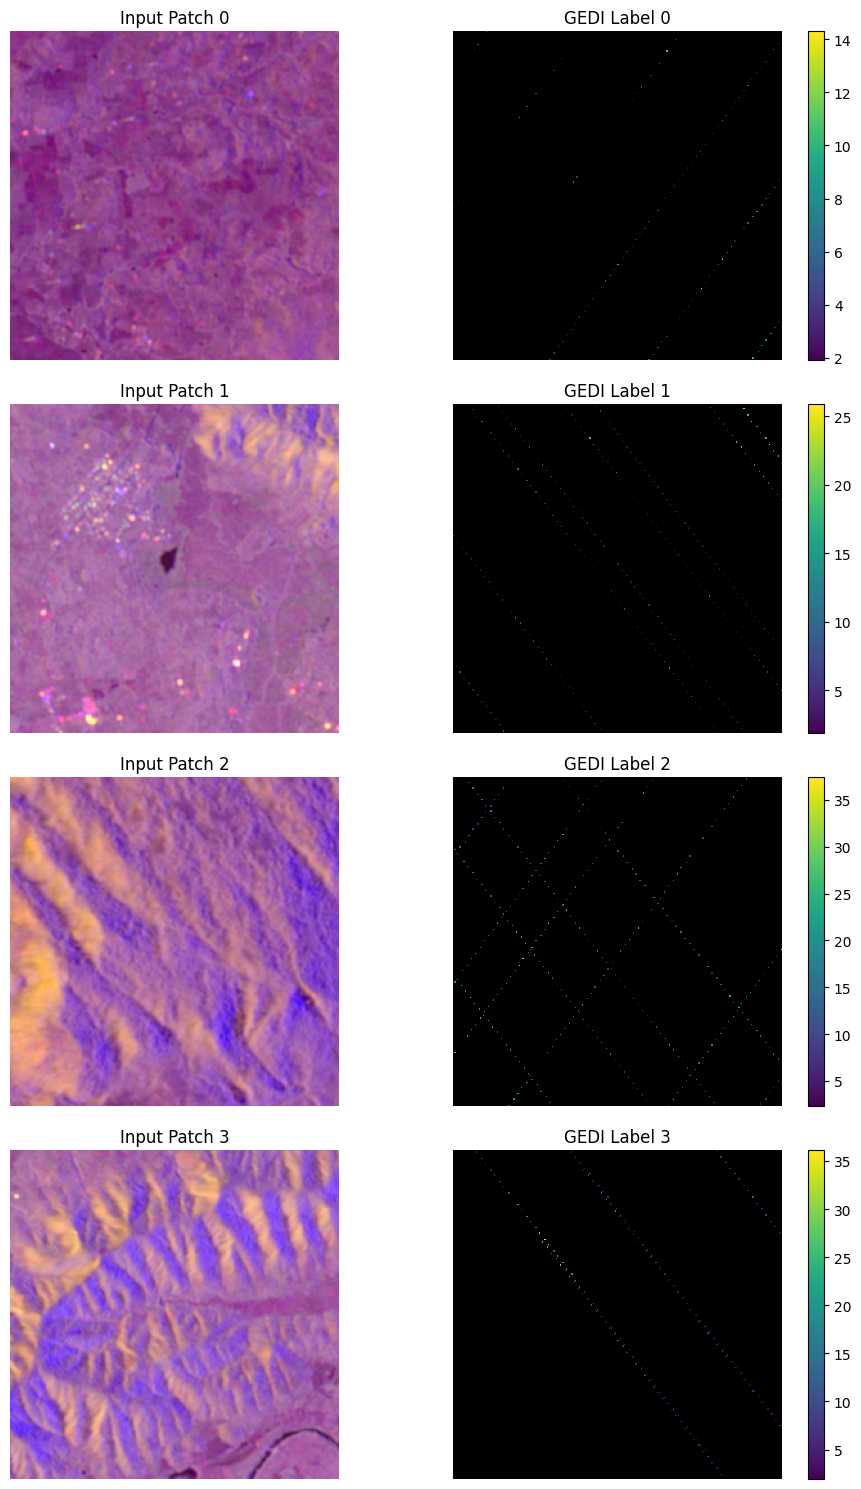

In [6]:
# Tạo dummy loader để check
check_dataset = TilePatchDataset(train_tiles, patch_size=Config.PATCH_SIZE, patches_per_epoch=4)
check_loader = DataLoader(check_dataset, batch_size=4, shuffle=True)

batch_img, batch_gedi = next(iter(check_loader))

print(f"Input shape: {batch_img.shape}")
print(f"Label shape: {batch_gedi.shape}")

# Vẽ hình
fig, axs = plt.subplots(4, 2, figsize=(10, 15))
for i in range(4):
    # Lấy 3 channels đầu tiên để hiển thị (Giả sử là RGB hoặc NIR-Red-Green)
    # Lưu ý: Cần normalize về 0-1 để hiển thị nếu ảnh raw giá trị lớn
    img_show = batch_img[i, 0:3].permute(1, 2, 0).numpy()
    img_show = (img_show - np.nanmin(img_show)) / (np.nanmax(img_show) - np.nanmin(img_show) + 1e-6)
    
    axs[i, 0].imshow(img_show)
    axs[i, 0].set_title(f"Input Patch {i}")
    axs[i, 0].axis('off')
    
    # Hiển thị GEDI (Sparse data)
    gedi_show = batch_gedi[i, 0].numpy()
    # Mask NaN để hiển thị đẹp hơn
    masked_gedi = np.ma.masked_where(np.isnan(gedi_show), gedi_show)
    
    cmap = plt.cm.viridis
    cmap.set_bad(color='black') # NaN set màu đen
    
    im = axs[i, 1].imshow(masked_gedi, cmap=cmap, interpolation='none')
    axs[i, 1].set_title(f"GEDI Label {i}")
    axs[i, 1].axis('off')
    plt.colorbar(im, ax=axs[i, 1])

plt.tight_layout()
plt.show()

In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.conv(x)

class UNetPlusPlus(nn.Module):
    # ... (Giữ nguyên code UNet++ của bạn ở trên) ...
    # Để tiết kiệm dòng hiển thị tôi không paste lại, bạn copy vào đây nhé
    def __init__(self, in_channels, out_channels):
        super().__init__()
        nb_filter = Config.NB_FILTERS
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv0_0 = ConvBlock(in_channels, nb_filter[0])
        self.conv1_0 = ConvBlock(nb_filter[0], nb_filter[1])
        self.conv2_0 = ConvBlock(nb_filter[1], nb_filter[2])
        self.conv3_0 = ConvBlock(nb_filter[2], nb_filter[3])
        self.conv4_0 = ConvBlock(nb_filter[3], nb_filter[4])
        
        self.conv0_1 = ConvBlock(nb_filter[0]+nb_filter[1], nb_filter[0])
        self.conv1_1 = ConvBlock(nb_filter[1]+nb_filter[2], nb_filter[1])
        self.conv2_1 = ConvBlock(nb_filter[2]+nb_filter[3], nb_filter[2])
        self.conv3_1 = ConvBlock(nb_filter[3]+nb_filter[4], nb_filter[3])
        
        self.conv0_2 = ConvBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0])
        self.conv1_2 = ConvBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1])
        self.conv2_2 = ConvBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2])
        
        self.conv0_3 = ConvBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0])
        self.conv1_3 = ConvBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1])
        
        self.conv0_4 = ConvBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0])
        self.final = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)

    def forward(self, x):
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x4_0 = self.conv4_0(self.pool(x3_0))
        
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))
        output = self.final(x0_4)
        return output

In [8]:
class MaskedMAELoss(nn.Module):
    def forward(self, pred, target):
        mask = ~torch.isnan(target)
        if mask.sum() == 0:
            return torch.tensor(0.0, device=pred.device, requires_grad=True)
        loss = torch.abs(pred[mask] - target[mask])
        return loss.mean()

def global_masked_r2(all_preds, all_targets):
    if len(all_targets) == 0: return 0.0
    y_pred = torch.cat(all_preds)
    y_true = torch.cat(all_targets)
    if len(y_true) < 2: return 0.0
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    return 1 - ss_res / (ss_tot + 1e-8)

In [9]:
# Setup Loaders
train_dataset = TilePatchDataset(train_tiles, patch_size=Config.PATCH_SIZE, patches_per_epoch=Config.PATCHES_PER_EPOCH)
test_dataset  = TileFullDataset(test_tiles)

train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Init Model
model = UNetPlusPlus(Config.IN_CHANNELS, Config.OUT_CHANNELS).to(Config.DEVICE)
optimizer = optim.Adam(model.parameters(), lr=Config.LR)
criterion = MaskedMAELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

history = {'train_loss': [], 'val_loss': [], 'val_r2': []} 

In [10]:
best_val_mae = float('inf')

print("Starting Training...")
for epoch in range(Config.EPOCHS):
    # -- Train --
    model.train()
    train_loss = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{Config.EPOCHS}")
    for imgs, targets in pbar:
        imgs = imgs.to(Config.DEVICE)
        targets = targets.to(Config.DEVICE)
        
        
        imgs = torch.nan_to_num(imgs, nan=0.0)
        
        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})
        
    avg_train_loss = train_loss / len(train_loader)

   
    model.eval()
    val_loss = 0
    val_preds_list = []
    val_targets_list = []
    
    with torch.no_grad():
        for imgs, targets in test_loader:
            imgs = imgs.to(Config.DEVICE)
            targets = targets.to(Config.DEVICE)
            imgs = torch.nan_to_num(imgs, nan=0.0)
            
            preds = model(imgs)
            loss = criterion(preds, targets)
            val_loss += loss.item()
            
            mask = ~torch.isnan(targets)
            if mask.sum() > 0:
                val_preds_list.append(preds[mask].cpu())
                val_targets_list.append(targets[mask].cpu())

    avg_val_mae = val_loss / len(test_loader)
    val_r2 = global_masked_r2(val_preds_list, val_targets_list)
    
    
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_mae)
    history['val_r2'].append(val_r2.item())
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}: Train MAE: {avg_train_loss:.4f} | Val MAE: {avg_val_mae:.4f} | Val R2: {val_r2:.4f} | LR: {current_lr:.2e}")
    
    scheduler.step(avg_val_mae)
    
    if avg_val_mae < best_val_mae:
        best_val_mae = avg_val_mae
        torch.save(model.state_dict(), Config.MODEL_SAVE_PATH)
        print(f"Saved Best Model (MAE: {best_val_mae:.4f})")

Starting Training...


Epoch 1/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1: Train MAE: 10.4093 | Val MAE: 9.3561 | Val R2: -0.9675 | LR: 1.00e-04
Saved Best Model (MAE: 9.3561)


Epoch 2/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 2: Train MAE: 10.1156 | Val MAE: 9.1024 | Val R2: -0.9490 | LR: 1.00e-04
Saved Best Model (MAE: 9.1024)


Epoch 3/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 3: Train MAE: 9.5246 | Val MAE: 9.0724 | Val R2: -0.9288 | LR: 1.00e-04
Saved Best Model (MAE: 9.0724)


Epoch 4/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 4: Train MAE: 9.3047 | Val MAE: 9.0126 | Val R2: -0.8839 | LR: 1.00e-04
Saved Best Model (MAE: 9.0126)


Epoch 5/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 5: Train MAE: 9.7892 | Val MAE: 8.9263 | Val R2: -0.9025 | LR: 1.00e-04
Saved Best Model (MAE: 8.9263)


Epoch 6/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 6: Train MAE: 9.1918 | Val MAE: 8.8009 | Val R2: -0.9651 | LR: 1.00e-04
Saved Best Model (MAE: 8.8009)


Epoch 7/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 7: Train MAE: 9.2174 | Val MAE: 8.3042 | Val R2: -0.7826 | LR: 1.00e-04
Saved Best Model (MAE: 8.3042)


Epoch 8/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 8: Train MAE: 8.9326 | Val MAE: 8.1388 | Val R2: -0.6946 | LR: 1.00e-04
Saved Best Model (MAE: 8.1388)


Epoch 9/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 9: Train MAE: 9.1274 | Val MAE: 8.0046 | Val R2: -0.6745 | LR: 1.00e-04
Saved Best Model (MAE: 8.0046)


Epoch 10/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 10: Train MAE: 8.7522 | Val MAE: 7.8881 | Val R2: -0.5895 | LR: 1.00e-04
Saved Best Model (MAE: 7.8881)


Epoch 11/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 11: Train MAE: 8.7242 | Val MAE: 7.4592 | Val R2: -0.5570 | LR: 1.00e-04
Saved Best Model (MAE: 7.4592)


Epoch 12/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 12: Train MAE: 8.1017 | Val MAE: 7.1364 | Val R2: -0.4389 | LR: 1.00e-04
Saved Best Model (MAE: 7.1364)


Epoch 13/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 13: Train MAE: 7.5637 | Val MAE: 7.0766 | Val R2: -0.4664 | LR: 1.00e-04
Saved Best Model (MAE: 7.0766)


Epoch 14/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 14: Train MAE: 7.6102 | Val MAE: 6.5409 | Val R2: -0.3333 | LR: 1.00e-04
Saved Best Model (MAE: 6.5409)


Epoch 15/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 15: Train MAE: 7.7927 | Val MAE: 6.8386 | Val R2: -0.3804 | LR: 1.00e-04


Epoch 16/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 16: Train MAE: 7.2715 | Val MAE: 6.3653 | Val R2: -0.2618 | LR: 1.00e-04
Saved Best Model (MAE: 6.3653)


Epoch 17/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 17: Train MAE: 6.7849 | Val MAE: 6.7473 | Val R2: -0.3539 | LR: 1.00e-04


Epoch 18/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 18: Train MAE: 6.6907 | Val MAE: 6.0535 | Val R2: -0.1492 | LR: 1.00e-04
Saved Best Model (MAE: 6.0535)


Epoch 19/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 19: Train MAE: 6.7625 | Val MAE: 5.7697 | Val R2: -0.1081 | LR: 1.00e-04
Saved Best Model (MAE: 5.7697)


Epoch 20/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 20: Train MAE: 6.7051 | Val MAE: 6.2539 | Val R2: -0.1897 | LR: 1.00e-04


Epoch 21/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 21: Train MAE: 6.0265 | Val MAE: 4.8891 | Val R2: 0.2146 | LR: 1.00e-04
Saved Best Model (MAE: 4.8891)


Epoch 22/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 22: Train MAE: 5.6873 | Val MAE: 4.6121 | Val R2: 0.3523 | LR: 1.00e-04
Saved Best Model (MAE: 4.6121)


Epoch 23/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 23: Train MAE: 5.3705 | Val MAE: 4.7660 | Val R2: 0.3383 | LR: 1.00e-04


Epoch 24/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 24: Train MAE: 6.0809 | Val MAE: 5.0373 | Val R2: 0.2410 | LR: 1.00e-04


Epoch 25/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 25: Train MAE: 5.4345 | Val MAE: 3.9566 | Val R2: 0.4789 | LR: 1.00e-04
Saved Best Model (MAE: 3.9566)


Epoch 26/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 26: Train MAE: 5.3653 | Val MAE: 4.8083 | Val R2: 0.3047 | LR: 1.00e-04


Epoch 27/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 27: Train MAE: 4.9446 | Val MAE: 4.0804 | Val R2: 0.4919 | LR: 1.00e-04


Epoch 28/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 28: Train MAE: 5.0842 | Val MAE: 5.6433 | Val R2: 0.1248 | LR: 1.00e-04


Epoch 29/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 29: Train MAE: 4.6105 | Val MAE: 3.6548 | Val R2: 0.5672 | LR: 1.00e-04
Saved Best Model (MAE: 3.6548)


Epoch 30/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 30: Train MAE: 4.4132 | Val MAE: 4.1901 | Val R2: 0.4435 | LR: 1.00e-04


Epoch 31/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 31: Train MAE: 4.2391 | Val MAE: 3.4714 | Val R2: 0.6233 | LR: 1.00e-04
Saved Best Model (MAE: 3.4714)


Epoch 32/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 32: Train MAE: 4.6401 | Val MAE: 3.5464 | Val R2: 0.6043 | LR: 1.00e-04


Epoch 33/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 33: Train MAE: 4.1356 | Val MAE: 3.5190 | Val R2: 0.5992 | LR: 1.00e-04


Epoch 34/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 34: Train MAE: 4.3943 | Val MAE: 3.7028 | Val R2: 0.6315 | LR: 1.00e-04


Epoch 35/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 35: Train MAE: 4.2130 | Val MAE: 3.4802 | Val R2: 0.6598 | LR: 1.00e-04


Epoch 36/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 36: Train MAE: 4.0688 | Val MAE: 3.4287 | Val R2: 0.6320 | LR: 1.00e-04
Saved Best Model (MAE: 3.4287)


Epoch 37/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 37: Train MAE: 4.1562 | Val MAE: 3.3758 | Val R2: 0.6766 | LR: 1.00e-04
Saved Best Model (MAE: 3.3758)


Epoch 38/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 38: Train MAE: 4.0502 | Val MAE: 3.3950 | Val R2: 0.7032 | LR: 1.00e-04


Epoch 39/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 39: Train MAE: 3.9552 | Val MAE: 3.3856 | Val R2: 0.6653 | LR: 1.00e-04


Epoch 40/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 40: Train MAE: 4.0430 | Val MAE: 3.3735 | Val R2: 0.6876 | LR: 1.00e-04
Saved Best Model (MAE: 3.3735)


Epoch 41/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 41: Train MAE: 3.7550 | Val MAE: 3.4668 | Val R2: 0.6876 | LR: 1.00e-04


Epoch 42/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 42: Train MAE: 3.8427 | Val MAE: 3.7843 | Val R2: 0.6786 | LR: 1.00e-04


Epoch 43/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 43: Train MAE: 3.7689 | Val MAE: 3.2493 | Val R2: 0.7000 | LR: 1.00e-04
Saved Best Model (MAE: 3.2493)


Epoch 44/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 44: Train MAE: 3.6708 | Val MAE: 3.7826 | Val R2: 0.5929 | LR: 1.00e-04


Epoch 45/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 45: Train MAE: 3.8234 | Val MAE: 3.2922 | Val R2: 0.6858 | LR: 1.00e-04


Epoch 46/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 46: Train MAE: 3.9897 | Val MAE: 3.1575 | Val R2: 0.6985 | LR: 1.00e-04
Saved Best Model (MAE: 3.1575)


Epoch 47/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 47: Train MAE: 3.9353 | Val MAE: 3.2590 | Val R2: 0.6940 | LR: 1.00e-04


Epoch 48/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 48: Train MAE: 3.7241 | Val MAE: 3.7803 | Val R2: 0.5897 | LR: 1.00e-04


Epoch 49/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 49: Train MAE: 3.7273 | Val MAE: 3.2559 | Val R2: 0.6846 | LR: 1.00e-04


Epoch 50/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 50: Train MAE: 3.5569 | Val MAE: 3.7059 | Val R2: 0.6159 | LR: 1.00e-04


Epoch 51/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 51: Train MAE: 3.6346 | Val MAE: 3.1024 | Val R2: 0.7088 | LR: 1.00e-04
Saved Best Model (MAE: 3.1024)


Epoch 52/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 52: Train MAE: 3.6753 | Val MAE: 3.1671 | Val R2: 0.7301 | LR: 1.00e-04


Epoch 53/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 53: Train MAE: 3.5910 | Val MAE: 3.4009 | Val R2: 0.7087 | LR: 1.00e-04


Epoch 54/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 54: Train MAE: 3.4155 | Val MAE: 3.1507 | Val R2: 0.7021 | LR: 1.00e-04


Epoch 55/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 55: Train MAE: 3.5020 | Val MAE: 3.1468 | Val R2: 0.7059 | LR: 1.00e-04


Epoch 56/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 56: Train MAE: 3.3608 | Val MAE: 3.2279 | Val R2: 0.6954 | LR: 1.00e-04


Epoch 57/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 57: Train MAE: 3.4137 | Val MAE: 3.4271 | Val R2: 0.6621 | LR: 1.00e-04


Epoch 58/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 58: Train MAE: 3.2605 | Val MAE: 3.0352 | Val R2: 0.7294 | LR: 5.00e-05
Saved Best Model (MAE: 3.0352)


Epoch 59/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 59: Train MAE: 3.2064 | Val MAE: 3.0986 | Val R2: 0.7127 | LR: 5.00e-05


Epoch 60/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 60: Train MAE: 3.1843 | Val MAE: 3.0429 | Val R2: 0.7239 | LR: 5.00e-05


Epoch 61/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 61: Train MAE: 3.1925 | Val MAE: 3.1052 | Val R2: 0.7299 | LR: 5.00e-05


Epoch 62/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 62: Train MAE: 3.1481 | Val MAE: 3.0517 | Val R2: 0.7278 | LR: 5.00e-05


Epoch 63/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 63: Train MAE: 3.1121 | Val MAE: 3.0488 | Val R2: 0.7355 | LR: 5.00e-05


Epoch 64/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 64: Train MAE: 3.1435 | Val MAE: 3.0789 | Val R2: 0.7242 | LR: 5.00e-05


Epoch 65/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 65: Train MAE: 3.2304 | Val MAE: 3.0362 | Val R2: 0.7339 | LR: 2.50e-05


Epoch 66/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 66: Train MAE: 3.1032 | Val MAE: 3.0175 | Val R2: 0.7284 | LR: 2.50e-05
Saved Best Model (MAE: 3.0175)


Epoch 67/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 67: Train MAE: 3.0395 | Val MAE: 3.0062 | Val R2: 0.7267 | LR: 2.50e-05
Saved Best Model (MAE: 3.0062)


Epoch 68/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 68: Train MAE: 2.9855 | Val MAE: 3.0609 | Val R2: 0.7127 | LR: 2.50e-05


Epoch 69/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 69: Train MAE: 3.0935 | Val MAE: 3.0668 | Val R2: 0.7170 | LR: 2.50e-05


Epoch 70/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 70: Train MAE: 2.9808 | Val MAE: 3.0248 | Val R2: 0.7215 | LR: 2.50e-05


Epoch 71/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 71: Train MAE: 3.0930 | Val MAE: 3.0851 | Val R2: 0.7116 | LR: 2.50e-05


Epoch 72/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 72: Train MAE: 2.9150 | Val MAE: 3.0236 | Val R2: 0.7262 | LR: 2.50e-05


Epoch 73/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 73: Train MAE: 2.9701 | Val MAE: 3.0070 | Val R2: 0.7273 | LR: 2.50e-05


Epoch 74/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 74: Train MAE: 2.9235 | Val MAE: 3.0737 | Val R2: 0.7080 | LR: 1.25e-05


Epoch 75/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 75: Train MAE: 2.8726 | Val MAE: 3.0183 | Val R2: 0.7230 | LR: 1.25e-05


Epoch 76/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 76: Train MAE: 2.7931 | Val MAE: 3.0311 | Val R2: 0.7207 | LR: 1.25e-05


Epoch 77/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 77: Train MAE: 2.8888 | Val MAE: 3.0481 | Val R2: 0.7190 | LR: 1.25e-05


Epoch 78/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 78: Train MAE: 2.9581 | Val MAE: 3.0571 | Val R2: 0.7166 | LR: 1.25e-05


Epoch 79/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 79: Train MAE: 2.9041 | Val MAE: 3.0089 | Val R2: 0.7212 | LR: 1.25e-05


Epoch 80/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 80: Train MAE: 2.9294 | Val MAE: 3.0132 | Val R2: 0.7293 | LR: 6.25e-06


Epoch 81/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 81: Train MAE: 2.8491 | Val MAE: 3.0144 | Val R2: 0.7260 | LR: 6.25e-06


Epoch 82/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 82: Train MAE: 2.8997 | Val MAE: 3.0530 | Val R2: 0.7132 | LR: 6.25e-06


Epoch 83/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 83: Train MAE: 2.8405 | Val MAE: 3.0252 | Val R2: 0.7176 | LR: 6.25e-06


Epoch 84/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 84: Train MAE: 2.8046 | Val MAE: 3.0498 | Val R2: 0.7139 | LR: 6.25e-06


Epoch 85/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 85: Train MAE: 2.7783 | Val MAE: 3.1015 | Val R2: 0.7022 | LR: 6.25e-06


Epoch 86/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 86: Train MAE: 2.8257 | Val MAE: 3.0027 | Val R2: 0.7327 | LR: 3.13e-06
Saved Best Model (MAE: 3.0027)


Epoch 87/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 87: Train MAE: 2.8307 | Val MAE: 3.0365 | Val R2: 0.7157 | LR: 3.13e-06


Epoch 88/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 88: Train MAE: 2.8109 | Val MAE: 3.0190 | Val R2: 0.7294 | LR: 3.13e-06


Epoch 89/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 89: Train MAE: 3.0162 | Val MAE: 3.0001 | Val R2: 0.7259 | LR: 3.13e-06
Saved Best Model (MAE: 3.0001)


Epoch 90/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 90: Train MAE: 2.8745 | Val MAE: 3.0315 | Val R2: 0.7197 | LR: 3.13e-06


Epoch 91/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 91: Train MAE: 2.9750 | Val MAE: 3.0863 | Val R2: 0.7047 | LR: 3.13e-06


Epoch 92/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 92: Train MAE: 2.8460 | Val MAE: 3.0366 | Val R2: 0.7180 | LR: 3.13e-06


Epoch 93/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 93: Train MAE: 2.8352 | Val MAE: 3.0199 | Val R2: 0.7221 | LR: 3.13e-06


Epoch 94/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 94: Train MAE: 2.8408 | Val MAE: 3.0232 | Val R2: 0.7206 | LR: 3.13e-06


Epoch 95/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 95: Train MAE: 2.9550 | Val MAE: 3.0287 | Val R2: 0.7195 | LR: 3.13e-06


Epoch 96/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 96: Train MAE: 2.8556 | Val MAE: 3.0406 | Val R2: 0.7172 | LR: 1.56e-06


Epoch 97/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 97: Train MAE: 2.8847 | Val MAE: 3.0186 | Val R2: 0.7287 | LR: 1.56e-06


Epoch 98/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 98: Train MAE: 2.9081 | Val MAE: 2.9988 | Val R2: 0.7290 | LR: 1.56e-06
Saved Best Model (MAE: 2.9988)


Epoch 99/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 99: Train MAE: 2.8657 | Val MAE: 3.0115 | Val R2: 0.7257 | LR: 1.56e-06


Epoch 100/100:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 100: Train MAE: 2.8418 | Val MAE: 3.0123 | Val R2: 0.7266 | LR: 1.56e-06


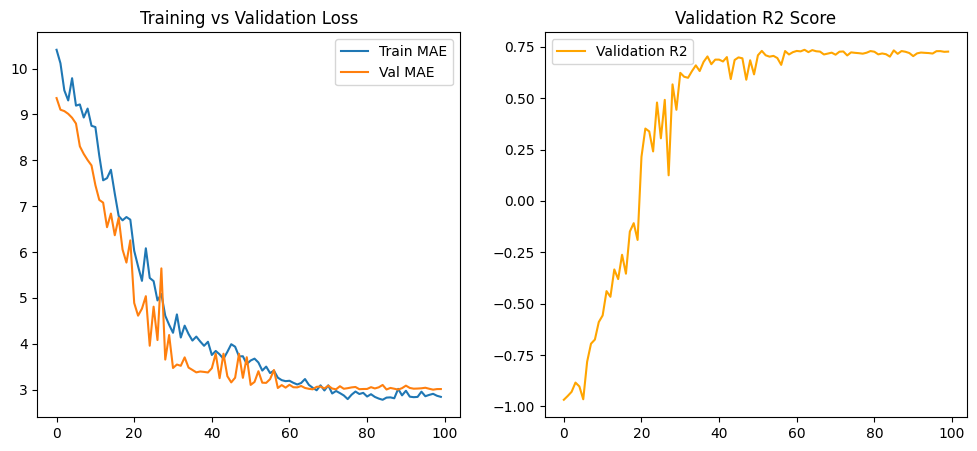

In [11]:
# Vẽ biểu đồ Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train MAE')
plt.plot(history['val_loss'], label='Val MAE')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_r2'], label='Validation R2', color='orange')
plt.title('Validation R2 Score')
plt.legend()

plt.show()

Loading Model...
✅ Load Weight thành công!
Reading TIF file...


Plotting...
✅ Xong! Kiểm tra file final_check_rgb.png


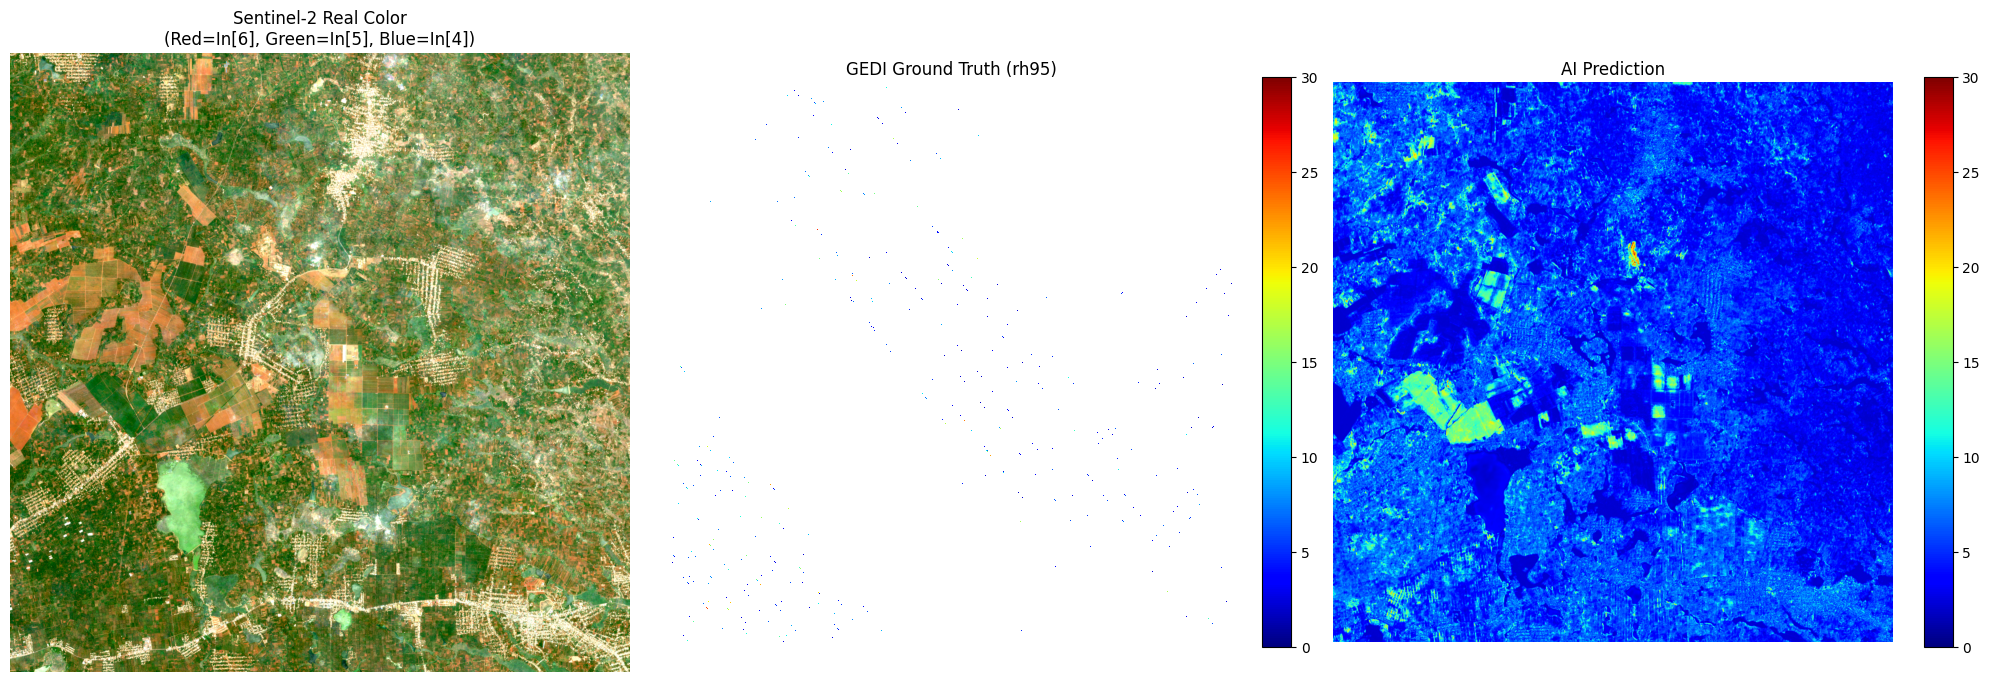

In [33]:
import rasterio
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

# ============================================================
# 1. CẤU HÌNH (ĐÃ CHỈNH THEO ẢNH BẠN GỬI)
# ============================================================
MODEL_PATH = "unetpp_best_model.pth"
TIFF_PATH = "../DakLak_Full_Merged_Final_Final.tif" # Đổi tên file nếu cần
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- CẤU HÌNH INDEX MÀU RGB ---
# Giải thích: 
# Trong file gốc: B4(Red)=7, B3(Green)=6, B2(Blue)=5
# Nhưng vì ta bỏ band đầu tiên (rh95) ra làm nhãn, nên index giảm đi 1 khi vào Model Input.
# Input bao gồm: [VV_a, VH_a, VV_d, VH_d, B2, B3, B4, ...]
# Index tương ứng: 0,    1,    2,    3,    4,  5,  6
R_IDX = 6  # Red
G_IDX = 5  # Green
B_IDX = 4  # Blue

# ============================================================
# 2. MODEL (In=14, Out=1)
# ============================================================
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.conv(x)

class NestedUNet(nn.Module):
    def __init__(self, in_channels=14, out_channels=1):
        super(NestedUNet, self).__init__()
        nb_filter = [32, 64, 128, 256, 512]
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)

        self.conv0_0 = ConvBlock(in_channels, nb_filter[0])
        self.conv1_0 = ConvBlock(nb_filter[0], nb_filter[1])
        self.conv2_0 = ConvBlock(nb_filter[1], nb_filter[2])
        self.conv3_0 = ConvBlock(nb_filter[2], nb_filter[3])
        self.conv4_0 = ConvBlock(nb_filter[3], nb_filter[4])

        self.conv0_1 = ConvBlock(nb_filter[0] + nb_filter[1], nb_filter[0])
        self.conv0_2 = ConvBlock(nb_filter[0] * 2 + nb_filter[1], nb_filter[0])
        self.conv0_3 = ConvBlock(nb_filter[0] * 3 + nb_filter[1], nb_filter[0])
        self.conv0_4 = ConvBlock(nb_filter[0] * 4 + nb_filter[1], nb_filter[0])

        self.conv1_1 = ConvBlock(nb_filter[1] + nb_filter[2], nb_filter[1])
        self.conv1_2 = ConvBlock(nb_filter[1] * 2 + nb_filter[2], nb_filter[1])
        self.conv1_3 = ConvBlock(nb_filter[1] * 3 + nb_filter[2], nb_filter[1])

        self.conv2_1 = ConvBlock(nb_filter[2] + nb_filter[3], nb_filter[2])
        self.conv2_2 = ConvBlock(nb_filter[2] * 2 + nb_filter[3], nb_filter[2])
        self.conv3_1 = ConvBlock(nb_filter[3] + nb_filter[4], nb_filter[3])
        self.final = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)

    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))
        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))
        return self.final(x0_4)

# ============================================================
# 3. HÀM TẠO ẢNH NATURAL COLOR (ĐẸP)
# ============================================================
def get_natural_image(img_data, r_idx, g_idx, b_idx):
    try:
        r = img_data[r_idx]
        g = img_data[g_idx]
        b = img_data[b_idx]
    except IndexError:
        print(f"❌ Lỗi Index: Input chỉ có {img_data.shape[0]} kênh. Bạn đang gọi kênh {r_idx},{g_idx},{b_idx}")
        return np.zeros((img_data.shape[1], img_data.shape[2], 3))

    rgb = np.dstack((r, g, b))
    
    # Kỹ thuật Percentile Stretching
    mask = rgb > 0
    if mask.sum() > 0:
        p2, p98 = np.percentile(rgb[mask], (2, 98))
        rgb = np.clip(rgb, p2, p98)
        # Normalize 0-1
        rgb = (rgb - p2) / (p98 - p2 + 1e-6)
    
    # Tăng sáng (Gamma correction)
    rgb = np.power(rgb, 0.7) 
    return rgb

# ============================================================
# 4. CHẠY CHƯƠNG TRÌNH
# ============================================================
def predict_and_plot():
    print("Loading Model...")
    model = NestedUNet(in_channels=14, out_channels=1).to(DEVICE)
    try:
        state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
        new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
        model.load_state_dict(new_state_dict)
        print("✅ Load Weight thành công!")
    except Exception as e:
        print(f"⚠️ Cảnh báo: {e}")
        print("⚠️ Đang chạy với weight khởi tạo ngẫu nhiên (chỉ để test visualize).")

    model.eval()

    print("Reading TIF file...")
    with rasterio.open(TIFF_PATH) as src:
        H, W = src.height, src.width
        # Cắt vùng giữa ảnh
        c_x, c_y = W // 2, H // 2
        window = rasterio.windows.Window(c_x - 1024, c_y - 1024, 2048, 2048)
        
        # --- ĐỌC DỮ LIỆU ĐÚNG THEO ẢNH MÀN HÌNH ---
        # 1. Nhãn (rh95) là Band đầu tiên (Index 1 trong Rasterio)
        gt_data = src.read(1, window=window).astype("float32")
        
        # 2. Input (Radar + Sentinel) là Band 2 đến 15 (Index 2->15 trong Rasterio)
        # Tổng cộng 14 bands
        input_data = src.read(list(range(2, 16)), window=window).astype("float32")

        # Normalize Input (Giả sử dữ liệu gốc 0-1)
        # Lưu ý: Sentinel-2 gốc thường là 0-10000, nếu dữ liệu bạn đã chia rồi thì bỏ dòng này
        input_norm = np.nan_to_num(input_data, nan=0.0)
        if np.max(input_norm) > 1000: 
             input_norm = input_norm / 10000.0

        # Predict
        input_tensor = torch.from_numpy(input_norm).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            pred = model(input_tensor).squeeze().cpu().numpy()

        # --- VISUALIZATION ---
        print("Plotting...")
        fig, ax = plt.subplots(1, 3, figsize=(20, 7))

        # 1. ẢNH MÀU THẬT (SENTINEL-2 RGB)
        # Dùng Index 6, 5, 4 đã cấu hình ở trên
        rgb_img = get_natural_image(input_norm, R_IDX, G_IDX, B_IDX)
        ax[0].imshow(rgb_img)
        ax[0].set_title(f"Sentinel-2 Real Color\n(Red=In[{R_IDX}], Green=In[{G_IDX}], Blue=In[{B_IDX}])")
        ax[0].axis('off')

        # 2. GROUND TRUTH (GEDI rh95)
        # Ẩn các điểm giá trị 0 (NoData)
        gt_masked = np.ma.masked_where(gt_data <= 0, gt_data)
        im1 = ax[1].imshow(gt_masked, cmap="jet", vmin=0, vmax=30, interpolation='none')
        ax[1].set_title("GEDI Ground Truth (rh95)")
        ax[1].axis('off')
        plt.colorbar(im1, ax=ax[1], fraction=0.046)

        # 3. PREDICTION
        pred_clean = np.clip(pred, 0, None)
        im2 = ax[2].imshow(pred_clean, cmap="jet", vmin=0, vmax=30)
        ax[2].set_title("AI Prediction")
        ax[2].axis('off')
        plt.colorbar(im2, ax=ax[2], fraction=0.046)

        plt.tight_layout()
        plt.savefig("final_check_rgb.png", dpi=300)
        print("✅ Xong! Kiểm tra file final_check_rgb.png")
        plt.show()

if __name__ == "__main__":
    predict_and_plot()

Canopy height - Min: nan, Max: nan
Basemap - Min: nan, Max: nan


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4859: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


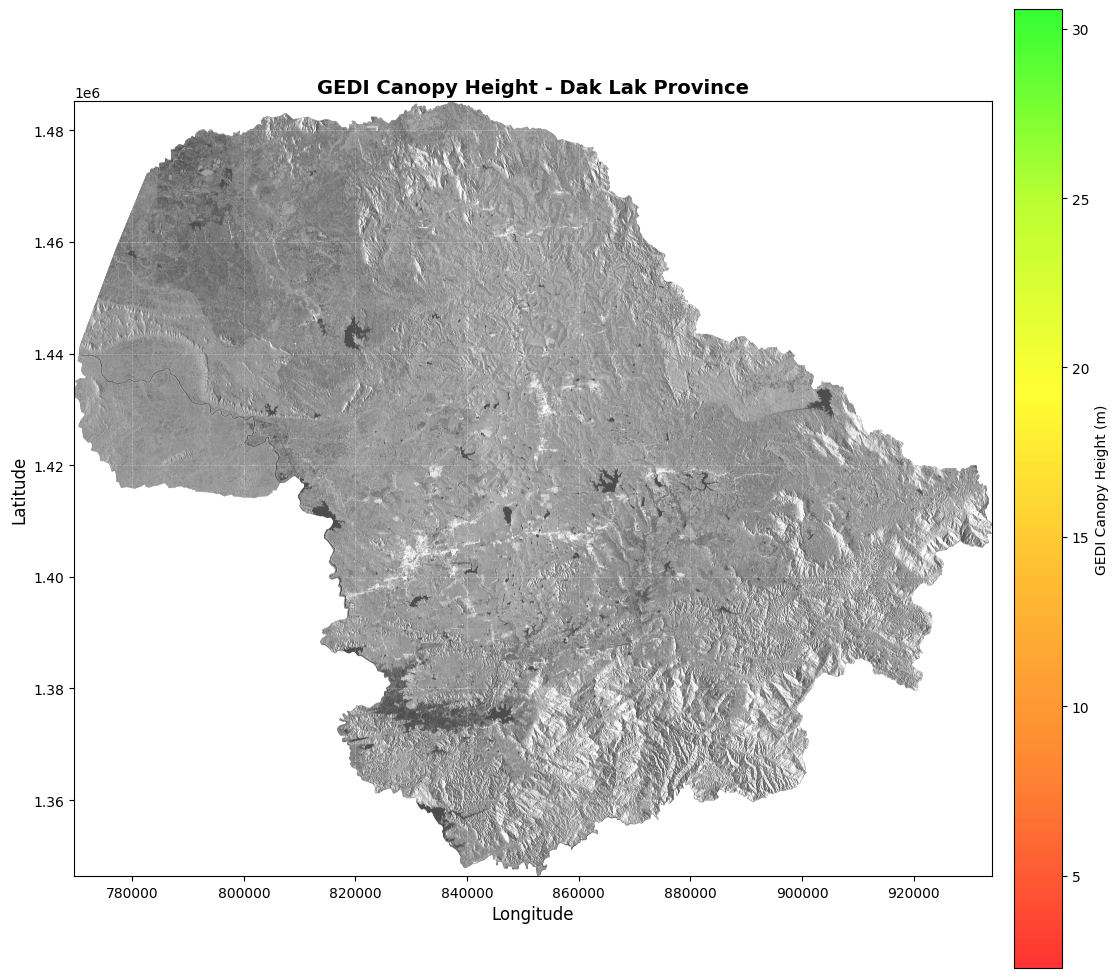

In [39]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

path = "../DakLak_Full_Merged_Final_Final.tif"

with rasterio.open(path) as src:
    # Đọc các bands
    # Band 0: Mosaic (GEDI canopy height)
    # Band 1: VV_ascending (Sentinel-1) - dùng làm basemap
    # Hoặc band 5-14: Sentinel-2 optical bands
    
    canopy_height = src.read(1, masked=True)  # Band 1: GEDI data
    basemap = src.read(2, masked=True)  # Band 2: VV_ascending (radar)
    # Hoặc dùng Sentinel-2: src.read(6) cho band B2 (blue)
    
    print(f"Canopy height - Min: {canopy_height.min()}, Max: {canopy_height.max()}")
    print(f"Basemap - Min: {basemap.min()}, Max: {basemap.max()}")
    
    extent = [src.bounds.left, src.bounds.right, 
              src.bounds.bottom, src.bounds.top]

# Color scheme cho GEDI
colors = ['#FF0000', '#FF6600', '#FFAA00', '#FFFF00', '#AAFF00', '#00FF00']
cmap = LinearSegmentedColormap.from_list('gedi', colors)

# Tạo figure
fig, ax = plt.subplots(figsize=(12, 14))

# 1. Vẽ basemap (Sentinel-1 VV hoặc Sentinel-2)
# Chuẩn hóa basemap về grayscale
basemap_norm = (basemap - np.nanpercentile(basemap, 2)) / \
               (np.nanpercentile(basemap, 98) - np.nanpercentile(basemap, 2))
basemap_norm = np.clip(basemap_norm, 0, 1)

im_base = ax.imshow(basemap_norm, cmap='gray', extent=extent, 
                    alpha=0.7, vmin=0, vmax=1)

# 2. Vẽ GEDI canopy height lên trên
im_canopy = ax.imshow(canopy_height, cmap=cmap, extent=extent,
                      vmin=2.27, vmax=30.58, alpha=0.8)

# 3. Colorbar
cbar = plt.colorbar(im_canopy, ax=ax, label='GEDI Canopy Height (m)', 
                    shrink=0.7, pad=0.02)

# 4. Labels và title
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('GEDI Canopy Height - Dak Lak Province', 
             fontsize=14, fontweight='bold')

# 5. Grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, color='white')

plt.tight_layout()
plt.show()

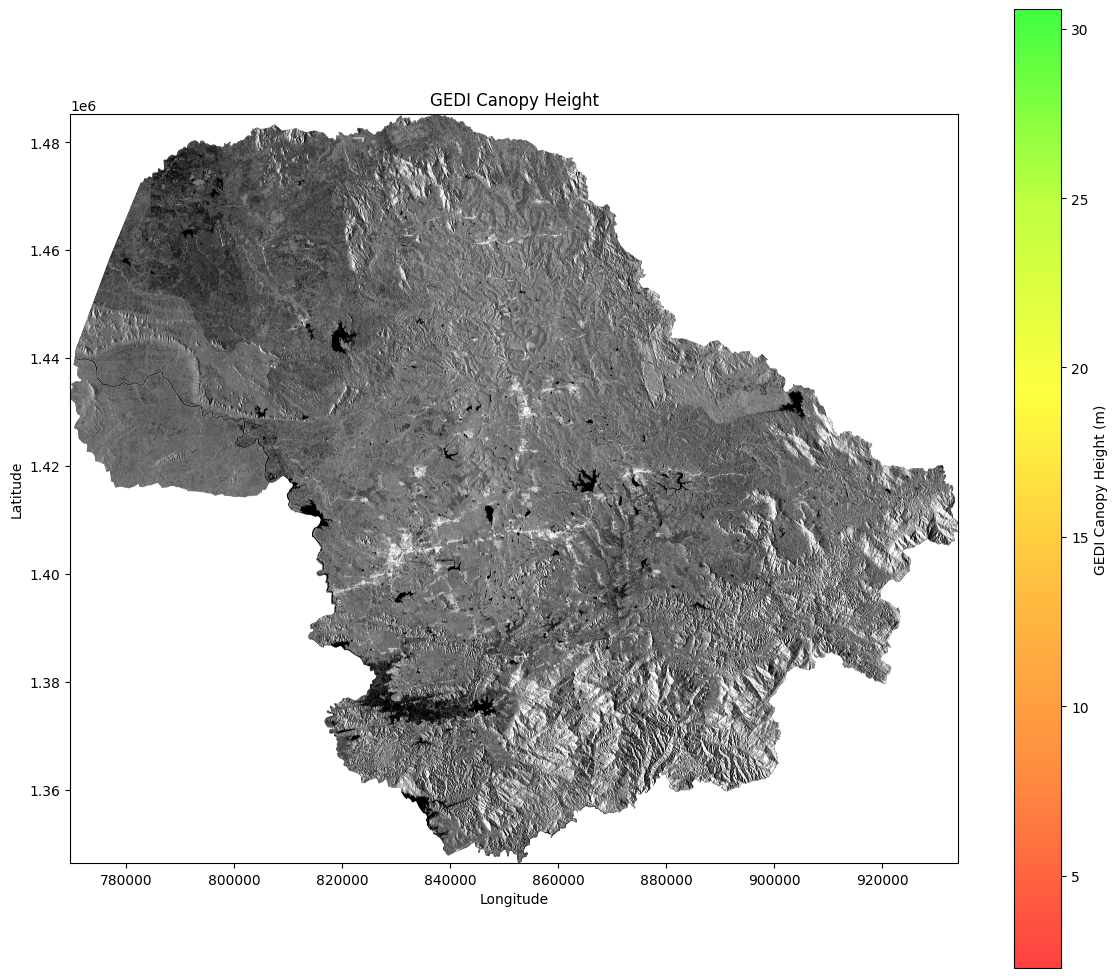

In [40]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

path = "../DakLak_Full_Merged_Final_Final.tif"

with rasterio.open(path) as src:
    canopy = src.read(1, masked=True)  # GEDI
    vv = src.read(2, masked=True)      # Sentinel-1 VV
    
    extent = [src.bounds.left, src.bounds.right, 
              src.bounds.bottom, src.bounds.top]

# Normalize VV (backscatter thường là giá trị âm trong dB)
vv_norm = (vv - np.nanpercentile(vv, 2)) / \
          (np.nanpercentile(vv, 98) - np.nanpercentile(vv, 2))
vv_norm = np.clip(vv_norm, 0, 1)

colors = ['#FF0000', '#FF6600', '#FFAA00', '#FFFF00', '#AAFF00', '#00FF00']
cmap = LinearSegmentedColormap.from_list('gedi', colors)

fig, ax = plt.subplots(figsize=(12, 14))

# Basemap xám
ax.imshow(vv_norm, cmap='gray', extent=extent, vmin=0, vmax=1)

# GEDI overlay
im = ax.imshow(canopy, cmap=cmap, extent=extent,
               vmin=0, vmax=60, alpha=0.75)

plt.colorbar(im, ax=ax, label='GEDI Canopy Height (m)', shrink=0.7)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('GEDI Canopy Height')

plt.tight_layout()
plt.show()

In [41]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

path = "../DakLak_Full_Merged_Final_Final.tif"

with rasterio.open(path) as src:
    print(f"Number of bands: {src.count}")
    print(f"NoData value: {src.nodata}")
    print(f"Data type: {src.dtypes}")
    print(f"Shape: {src.shape}")
    
    # Đọc KHÔNG mask trước để kiểm tra
    canopy = src.read(1)
    basemap = src.read(2)
    
    print(f"\n=== Band 1 (Canopy) ===")
    print(f"Raw min: {np.min(canopy)}, max: {np.max(canopy)}")
    print(f"Unique values (first 10): {np.unique(canopy)[:10]}")
    print(f"Non-zero count: {np.count_nonzero(canopy != 0)}")
    
    print(f"\n=== Band 2 (Basemap) ===")
    print(f"Raw min: {np.min(basemap)}, max: {np.max(basemap)}")
    print(f"Unique values (first 10): {np.unique(basemap)[:10]}")
    print(f"Non-zero count: {np.count_nonzero(basemap != 0)}")
    
    # Xác định NoData value
    nodata = src.nodata if src.nodata is not None else 0
    
    # Mask giá trị NoData
    canopy_masked = np.ma.masked_equal(canopy, nodata)
    basemap_masked = np.ma.masked_equal(basemap, nodata)
    
    # Nếu vẫn toàn NaN, thử mask giá trị âm hoặc 0
    if canopy_masked.count() == 0:
        print("\n⚠️ Tất cả bị mask! Thử các cách khác...")
        canopy_masked = np.ma.masked_where(canopy <= 0, canopy)
        basemap_masked = np.ma.masked_where(basemap <= 0, basemap)
    
    print(f"\n=== After masking ===")
    print(f"Canopy valid pixels: {canopy_masked.count()}")
    print(f"Basemap valid pixels: {basemap_masked.count()}")
    
    if canopy_masked.count() > 0:
        print(f"Canopy min: {canopy_masked.min()}, max: {canopy_masked.max()}")
    if basemap_masked.count() > 0:
        print(f"Basemap min: {basemap_masked.min()}, max: {basemap_masked.max()}")

Number of bands: 15
NoData value: None
Data type: ('float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64')
Shape: (13879, 16445)

=== Band 1 (Canopy) ===
Raw min: nan, max: nan
Unique values (first 10): [0.88999999 0.97000003 1.26999998 1.29999995 1.34000003 1.49000001
 1.63999999 1.67999995 1.72000003 1.75      ]
Non-zero count: 228240155

=== Band 2 (Basemap) ===
Raw min: nan, max: nan
Unique values (first 10): [0.14699166 0.15038171 0.15446109 0.15575247 0.15610162 0.16438324
 0.16629078 0.16653943 0.16706178 0.16729331]
Non-zero count: 228240155

=== After masking ===
Canopy valid pixels: 228240155
Basemap valid pixels: 228240155
Canopy min: nan, max: nan
Basemap min: nan, max: nan


In [ ]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

path = "../DakLak_Full_Merged_Final_Final.tif"

with rasterio.open(path) as src:
    # Đọc dữ liệu
    canopy = src.read(1)
    basemap = src.read(2)
    
    extent = [src.bounds.left, src.bounds.right, 
              src.bounds.bottom, src.bounds.top]
    
    # Mask NaN và giá trị 0
    canopy_valid = canopy[(~np.isnan(canopy)) & (canopy > 0)]
    basemap_valid = basemap[(~np.isnan(basemap)) & (basemap > 0)]
    
    print(f"Canopy valid pixels: {len(canopy_valid)}")
    print(f"Canopy min: {canopy_valid.min():.2f}, max: {canopy_valid.max():.2f}")
    print(f"Basemap valid pixels: {len(basemap_valid)}")
    print(f"Basemap min: {basemap_valid.min():.4f}, max: {basemap_valid.max():.4f}")
    
    # Tạo mask cho visualization
    canopy_masked = np.where((np.isnan(canopy)) | (canopy <= 0), np.nan, canopy)
    basemap_masked = np.where(np.isnan(basemap), np.nan, basemap)

# Normalize basemap về 0-1
p2, p98 = np.nanpercentile(basemap_masked, [2, 98])
basemap_norm = (basemap_masked - p2) / (p98 - p2)
basemap_norm = np.clip(basemap_norm, 0, 1)

# Color scheme
colors = ['#FF0000', '#FF6600', '#FFAA00', '#FFFF00', '#AAFF00', '#00FF00']
cmap = LinearSegmentedColormap.from_list('gedi', colors)

# Create figure
fig, ax = plt.subplots(figsize=(14, 16))

# 1. Plot basemap (gray background)
im_base = ax.imshow(basemap_norm, cmap='gray', extent=extent, 
                    alpha=0.6, interpolation='bilinear')

# 2. Plot GEDI canopy height overlay
im_canopy = ax.imshow(canopy_masked, cmap=cmap, extent=extent,
                      vmin=2.27, vmax=30.58, alpha=0.85, 
                      interpolation='nearest')

# 3. Colorbar
cbar = plt.colorbar(im_canopy, ax=ax, label='GEDI Canopy Height (m)', 
                    shrink=0.7, pad=0.02)
cbar.ax.tick_params(labelsize=10)

# 4. Labels and title
ax.set_xlabel('Longitude', fontsize=12, fontweight='bold')
ax.set_ylabel('Latitude', fontsize=12, fontweight='bold')
ax.set_title('GEDI Canopy Height - Dak Lak Province', 
             fontsize=15, fontweight='bold', pad=20)

# 5. Grid
ax.grid(True, alpha=0.25, linestyle='--', linewidth=0.5, color='white')

# 6. Set aspect ratio
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

# Thống kê
print(f"\n=== Statistics ===")
print(f"Total pixels: {canopy.size:,}")
print(f"Valid canopy pixels: {len(canopy_valid):,} ({len(canopy_valid)/canopy.size*100:.2f}%)")
print(f"Canopy height range: {canopy_valid.min():.2f}m - {canopy_valid.max():.2f}m")
print(f"Mean canopy height: {canopy_valid.mean():.2f}m")

In [ ]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

path = "../DakLak_Full_Merged_Final_Final.tif"

with rasterio.open(path) as src:
    canopy = src.read(1)
    basemap = src.read(2)
    
    # Lấy indices của pixels có dữ liệu
    valid_mask = (~np.isnan(canopy)) & (canopy > 0)
    rows, cols = np.where(valid_mask)
    
    # Chuyển đổi sang tọa độ địa lý
    xs, ys = rasterio.transform.xy(src.transform, rows, cols)
    values = canopy[rows, cols]
    
    print(f"Valid data points: {len(values):,}")
    print(f"Value range: {values.min():.2f} - {values.max():.2f}")
    
    # Basemap for background
    basemap_masked = np.where(np.isnan(basemap), np.nan, basemap)
    p2, p98 = np.nanpercentile(basemap_masked, [2, 98])
    basemap_norm = np.clip((basemap_masked - p2) / (p98 - p2), 0, 1)
    extent = [src.bounds.left, src.bounds.right, 
              src.bounds.bottom, src.bounds.top]

# Color scheme
colors = ['#FF0000', '#FF6600', '#FFAA00', '#FFFF00', '#AAFF00', '#00FF00']
cmap = LinearSegmentedColormap.from_list('gedi', colors)

# Plot
fig, ax = plt.subplots(figsize=(14, 16))

# Background
ax.imshow(basemap_norm, cmap='gray', extent=extent, alpha=0.5)

# Scatter plot GEDI points
scatter = ax.scatter(xs, ys, c=values, cmap=cmap, 
                     s=0.5, vmin=2.27, vmax=30.58,
                     edgecolors='none', alpha=0.9, 
                     rasterized=True)  # rasterized=True để render nhanh hơn

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, label='GEDI Canopy Height (m)', 
                    shrink=0.7, pad=0.02)

ax.set_xlabel('Longitude', fontsize=12, fontweight='bold')
ax.set_ylabel('Latitude', fontsize=12, fontweight='bold')
ax.set_title('GEDI Canopy Height - Dak Lak Province', 
             fontsize=15, fontweight='bold')

ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5, color='white')
ax.set_facecolor('#808080')

plt.tight_layout()
plt.show()

In [ ]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

path = "../DakLak_Full_Merged_Final_Final.tif"

with rasterio.open(path) as src:
    print(f"Number of bands: {src.count}")
    print(f"NoData value: {src.nodata}")
    print(f"Data type: {src.dtypes}")
    print(f"Shape: {src.shape}")
    
    # Đọc KHÔNG mask trước để kiểm tra
    canopy = src.read(1)
    basemap = src.read(2)
    
    print(f"\n=== Band 1 (Canopy) ===")
    print(f"Raw min: {np.min(canopy)}, max: {np.max(canopy)}")
    print(f"Unique values (first 10): {np.unique(canopy)[:10]}")
    print(f"Non-zero count: {np.count_nonzero(canopy != 0)}")
    
    print(f"\n=== Band 2 (Basemap) ===")
    print(f"Raw min: {np.min(basemap)}, max: {np.max(basemap)}")
    print(f"Unique values (first 10): {np.unique(basemap)[:10]}")
    print(f"Non-zero count: {np.count_nonzero(basemap != 0)}")
    
    # Xác định NoData value
    nodata = src.nodata if src.nodata is not None else 0
    
    # Mask giá trị NoData
    canopy_masked = np.ma.masked_equal(canopy, nodata)
    basemap_masked = np.ma.masked_equal(basemap, nodata)
    
    # Nếu vẫn toàn NaN, thử mask giá trị âm hoặc 0
    if canopy_masked.count() == 0:
        print("\n⚠️ Tất cả bị mask! Thử các cách khác...")
        canopy_masked = np.ma.masked_where(canopy <= 0, canopy)
        basemap_masked = np.ma.masked_where(basemap <= 0, basemap)
    
    print(f"\n=== After masking ===")
    print(f"Canopy valid pixels: {canopy_masked.count()}")
    print(f"Basemap valid pixels: {basemap_masked.count()}")
    
    if canopy_masked.count() > 0:
        print(f"Canopy min: {canopy_masked.min()}, max: {canopy_masked.max()}")
    if basemap_masked.count() > 0:
        print(f"Basemap min: {basemap_masked.min()}, max: {basemap_masked.max()}")